# Smart Retrieval SLM Analysis

## Hypothesis
**"High-quality retrieval can compensate for smaller, faster LLMs."**

This notebook analyzes experiment results with proper handling of:
- **Stratified sampling** (non-uniform experiment counts)
- **Component-wise effect estimation** with confidence intervals
- **Bottleneck identification** for maximizing QA performance

### Analysis Dimensions
| Dimension | Values | Description |
|-----------|--------|-------------|
| Model | Llama-3.2-3B, Phi-3-mini, Qwen-2.5-3B | Generator LLM |
| Retriever Type | dense, hybrid, hierarchical | Retrieval strategy |
| Embedding Model | bge-large, bge-m3, gte-qwen2, e5-mistral | Embedding model |
| Query Transform | none, hyde, multiquery | Query preprocessing |
| Reranker | none, bge, bge-v2 | Cross-encoder reranking |
| Prompt | concise, structured, cot, fewshot_3 | Prompt template |
| Top-K | 3, 5, 10 | Retrieved documents |
| Dataset | nq, triviaqa, hotpotqa | Evaluation benchmark |

In [48]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any, Optional, Tuple
from scipy import stats as scipy_stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paths
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

# Metrics to analyze
METRICS = ['f1', 'exact_match', 'bertscore', 'bleurt', 'llm_judge']
PRIMARY_METRIC = 'f1'

print(f"Study path: {STUDY_PATH}")
print(f"Exists: {STUDY_PATH.exists()}")

Study path: ../outputs/smart_retrieval_slm
Exists: True


## 1. Data Loading & Parsing

Parse experiment names following the naming convention:
- Direct: `direct_{model}_{prompt}_{dataset}`
- RAG: `rag_{model}_{retriever}_k{top_k}_{query_transform?}_{reranker?}_{prompt}_{dataset}`

In [49]:
# Model name mappings
MODEL_MAP = {
    'llama': 'Llama-3.2-3B',
    'Llama3.23BInstruct': 'Llama-3.2-3B',
    'phi': 'Phi-3-mini',
    'Phi3mini4kinstruct': 'Phi-3-mini',
    'qwen': 'Qwen-2.5-3B',
    'Qwen2.53BInstruct': 'Qwen-2.5-3B',
}

# Retriever type detection
RETRIEVER_TYPES = {
    'dense': ['dense_bge', 'dense_gte', 'dense_e5', 'en_bge', 'en_gte', 'en_e5'],
    'hybrid': ['hybrid_'],
    'hierarchical': ['hier_', 'hierarchical_'],
}

# Embedding model detection
EMBEDDING_MAP = {
    'bge_large': 'BGE-large',
    'bge_m3': 'BGE-M3',
    'gte_qwen2': 'GTE-Qwen2-1.5B',
    'e5_mistral': 'E5-Mistral-7B',
}


def parse_experiment_name(name: str) -> Dict[str, Any]:
    """Parse experiment name into structured components.
    
    Handles formats:
    - direct_vllm_metallamaLlama3.23BInstruct_concise_nq
    - rag_vllm_metallamaLlama3.23BInstruct_dense_bge_large_512_k5_hyde_bge_concise_nq
    - Singleton experiments (iterative_*, selfrag_*, premium_*)
    """
    config = {
        'name': name,
        'exp_type': 'unknown',
        'model': 'unknown',
        'model_short': 'unknown',
        'dataset': 'unknown',
        'prompt': 'unknown',
        'retriever': None,
        'retriever_type': None,
        'embedding_model': None,
        'top_k': None,
        'query_transform': 'none',
        'reranker': 'none',
        'is_singleton': False,
    }
    
    # Detect dataset (at end of name)
    for ds in ['nq', 'triviaqa', 'hotpotqa']:
        if name.endswith(f'_{ds}'):
            config['dataset'] = ds
            break
    
    # Fallback: look for dataset anywhere in the name
    if config['dataset'] == 'unknown':
        for ds in ['triviaqa', 'hotpotqa', 'nq']:  # nq last since it's short
            if f'_{ds}_' in name or f'_{ds}' in name:
                config['dataset'] = ds
                break
    
    # Handle singleton experiments
    if name.startswith('iterative_') or name.startswith('selfrag_') or name.startswith('premium_'):
        config['is_singleton'] = True
        config['exp_type'] = 'rag'
        if 'llama' in name.lower():
            config['model_short'] = 'Llama-3.2-3B'
        elif 'phi' in name.lower():
            config['model_short'] = 'Phi-3-mini'
        elif 'qwen' in name.lower():
            config['model_short'] = 'Qwen-2.5-3B'
        
        if name.startswith('iterative_'):
            config['retriever_type'] = 'iterative'
            # Parse iterations
            iter_match = re.search(r'(\d+)iter', name)
            config['query_transform'] = f"iterative_{iter_match.group(1)}" if iter_match else 'iterative'
        elif name.startswith('selfrag_'):
            config['retriever_type'] = 'self_rag'
            config['query_transform'] = 'self_rag'
        elif name.startswith('premium_'):
            config['retriever_type'] = 'hybrid'
            config['query_transform'] = 'hyde'
            config['reranker'] = 'bge-v2'
        return config
    
    # Direct experiments
    if name.startswith('direct_'):
        config['exp_type'] = 'direct'
        # Parse model from name
        for key, display in MODEL_MAP.items():
            if key.lower() in name.lower():
                config['model_short'] = display
                break
        # Parse prompt (before dataset)
        for prompt in ['concise', 'structured', 'cot', 'fewshot_3', 'fewshot', 'extractive', 'cited']:
            if f'_{prompt}_' in name or name.endswith(f'_{prompt}_{config["dataset"]}'):
                config['prompt'] = prompt
                break
        return config
    
    # RAG experiments
    if name.startswith('rag_'):
        config['exp_type'] = 'rag'
        
        # Parse model
        for key, display in MODEL_MAP.items():
            if key.lower() in name.lower():
                config['model_short'] = display
                break
        
        # Parse top_k
        k_match = re.search(r'_k(\d+)_', name)
        if k_match:
            config['top_k'] = int(k_match.group(1))
        
        # Parse retriever type and embedding model
        for rtype, patterns in RETRIEVER_TYPES.items():
            for pattern in patterns:
                if pattern in name.lower():
                    config['retriever_type'] = rtype
                    break
        
        for key, display in EMBEDDING_MAP.items():
            if key in name.lower():
                config['embedding_model'] = display
                break
        
        # Parse query transform
        if '_hyde_' in name.lower():
            config['query_transform'] = 'hyde'
        elif '_multiquery_' in name.lower():
            config['query_transform'] = 'multiquery'
        
        # Parse reranker
        if '_bgev2_' in name.lower() or '_bge-v2_' in name.lower():
            config['reranker'] = 'bge-v2'
        elif '_bge_' in name.lower() and config['embedding_model'] is None:
            # bge in name but not as embedding = reranker
            config['reranker'] = 'bge'
        
        # Parse prompt
        for prompt in ['concise', 'structured', 'cot', 'fewshot_3', 'fewshot', 'extractive', 'cited']:
            if f'_{prompt}_' in name:
                config['prompt'] = prompt
                break
        
        # Extract full retriever name
        # Pattern: after model, before _k{n}_
        if k_match:
            retriever_match = re.search(r'Instruct_(.+?)_k\d+', name)
            if retriever_match:
                config['retriever'] = retriever_match.group(1)
    
    return config


def load_all_results(study_path: Path) -> pd.DataFrame:
    """Load all experiment results into a DataFrame."""
    results = []
    loading_errors = []
    
    if not study_path.exists():
        print(f"Warning: Study path does not exist: {study_path}")
        return pd.DataFrame()
    
    for exp_dir in study_path.iterdir():
        if not exp_dir.is_dir():
            continue
        
        # Try results.json first, then metadata.json
        results_file = exp_dir / "results.json"
        metadata_file = exp_dir / "metadata.json"
        
        data = None
        if results_file.exists():
            with open(results_file) as f:
                data = json.load(f)
        elif metadata_file.exists():
            with open(metadata_file) as f:
                data = json.load(f)
            # Also load summary if exists
            summary_files = list(exp_dir.glob("*_summary.json"))
            if summary_files:
                with open(summary_files[0]) as f:
                    summary = json.load(f)
                data['metrics'] = summary.get('overall_metrics', summary)
        
        if data is None:
            continue
        
        try:
            # Parse experiment name
            exp_name = data.get('name', exp_dir.name)
            config = parse_experiment_name(exp_name)
            
            # Add metrics
            row = config.copy()
            metrics = data.get('metrics', data)
            
            # Handle case where metrics is a list (e.g., per-sample metrics)
            if isinstance(metrics, list):
                # Try to find overall_metrics in the data instead
                metrics = data.get('overall_metrics', {})
            
            # Handle case where metrics is nested under another key
            if not isinstance(metrics, dict):
                metrics = {}
            
            for metric in METRICS:
                if metric in metrics:
                    row[metric] = metrics[metric]
                elif metric in data:
                    row[metric] = data[metric]
            
            # Add sample count and timing
            row['n_samples'] = data.get('n_samples', data.get('num_questions', None))
            row['duration'] = data.get('duration', 0)
            row['throughput'] = data.get('throughput_qps', 0)
            
            results.append(row)
        except Exception as e:
            loading_errors.append((exp_dir.name, str(e)))
    
    # Report loading errors
    if loading_errors:
        print(f"⚠️ Failed to load {len(loading_errors)} experiments:")
        for name, error in loading_errors:
            print(f"   {name}: {error}")
        print()
    
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values(['exp_type', 'model_short', 'dataset']).reset_index(drop=True)
    
    return df


# Load data
df = load_all_results(STUDY_PATH)
print(f"Loaded {len(df)} experiments")

if len(df) > 0:
    print(f"\nExperiment types: {df['exp_type'].value_counts().to_dict()}")
    print(f"Models: {sorted(df['model_short'].dropna().unique())}")
    print(f"Datasets: {sorted(df['dataset'].dropna().unique())}")
    print(f"Retriever types: {df['retriever_type'].dropna().unique().tolist()}")
    print(f"\nMetrics available: {[m for m in METRICS if m in df.columns]}")

Loaded 128 experiments

Experiment types: {'rag': 110, 'direct': 18}
Models: ['Llama-3.2-3B', 'Phi-3-mini', 'Qwen-2.5-3B']
Datasets: ['hotpotqa', 'nq', 'triviaqa']
Retriever types: ['dense', 'hybrid', 'hierarchical']

Metrics available: ['f1', 'exact_match', 'bleurt']


In [50]:
# Data Quality Check
if len(df) > 0:
    print("Data Quality Check")
    print("="*60)
    
    # Check for unknown datasets
    unknown_ds = df[df['dataset'] == 'unknown']
    if len(unknown_ds) > 0:
        print(f"\n⚠️ Found {len(unknown_ds)} experiments with 'unknown' dataset:")
        for _, row in unknown_ds.iterrows():
            print(f"   {row['name']}")
        print("\n   → These need fixing in parse_experiment_name() or experiment naming.")
    else:
        print("\n✅ All experiments have known datasets.")
    
    # Check for unknown models
    unknown_model = df[df['model_short'] == 'unknown']
    if len(unknown_model) > 0:
        print(f"\n⚠️ Found {len(unknown_model)} experiments with 'unknown' model:")
        for _, row in unknown_model.iterrows():
            print(f"   {row['name']}")
    else:
        print("✅ All experiments have known models.")
    
    # Check for missing metrics
    missing_metric = df[PRIMARY_METRIC].isna()
    if missing_metric.sum() > 0:
        print(f"\n⚠️ Found {missing_metric.sum()} experiments with missing {PRIMARY_METRIC}.")
    else:
        print(f"✅ All experiments have {PRIMARY_METRIC} metric.")

Data Quality Check

✅ All experiments have known datasets.
✅ All experiments have known models.

⚠️ Found 4 experiments with missing f1.


In [51]:
# Show experiment distribution (important for stratified sampling)
if len(df) > 0:
    print("Experiment Distribution (crucial for weighted analysis)")
    print("="*60)
    
    # By key dimensions
    for dim in ['model_short', 'retriever_type', 'query_transform', 'reranker', 'prompt', 'dataset']:
        if dim in df.columns:
            counts = df[dim].value_counts()
            print(f"\n{dim}:")
            for val, count in counts.items():
                print(f"  {val}: {count}")

Experiment Distribution (crucial for weighted analysis)

model_short:
  Llama-3.2-3B: 45
  Qwen-2.5-3B: 44
  Phi-3-mini: 39

retriever_type:
  dense: 56
  hybrid: 40
  hierarchical: 14

query_transform:
  none: 64
  hyde: 37
  multiquery: 27

reranker:
  none: 100
  bge-v2: 28

prompt:
  concise: 60
  fewshot_3: 29
  cot: 21
  structured: 18

dataset:
  hotpotqa: 47
  nq: 44
  triviaqa: 37


## 2. Weighted Analysis Functions

With stratified sampling, we have non-uniform experiment counts.
We use **inverse frequency weighting** and **bootstrap confidence intervals**.

In [52]:
def weighted_mean_with_ci(
    df: pd.DataFrame, 
    group_col: str, 
    metric: str = PRIMARY_METRIC,
    weight_by: str = None,
    confidence: float = 0.95,
    n_bootstrap: int = 1000,
) -> pd.DataFrame:
    """
    Compute weighted mean with bootstrap confidence intervals.
    
    Args:
        df: DataFrame with experiment results
        group_col: Column to group by
        metric: Metric to analyze
        weight_by: Column to use for inverse frequency weighting (e.g., 'dataset')
        confidence: Confidence level for CI
        n_bootstrap: Number of bootstrap samples
    """
    if metric not in df.columns:
        return pd.DataFrame()
    
    results = []
    
    for group_val, group_df in df.groupby(group_col):
        values = group_df[metric].dropna().values
        if len(values) == 0:
            continue
        
        # Compute weights if specified
        if weight_by and weight_by in group_df.columns:
            # Inverse frequency weighting
            weight_counts = group_df[weight_by].value_counts()
            weights = group_df[weight_by].map(lambda x: 1.0 / weight_counts.get(x, 1))
            weights = weights / weights.sum()  # Normalize
            weighted_mean = (group_df[metric] * weights).sum()
        else:
            weighted_mean = np.mean(values)
            weights = None
        
        # Bootstrap CI
        if len(values) >= 3:
            bootstrap_means = []
            for _ in range(n_bootstrap):
                sample = np.random.choice(values, size=len(values), replace=True)
                bootstrap_means.append(np.mean(sample))
            alpha = (1 - confidence) / 2
            ci_low = np.percentile(bootstrap_means, alpha * 100)
            ci_high = np.percentile(bootstrap_means, (1 - alpha) * 100)
        else:
            ci_low = ci_high = weighted_mean
        
        results.append({
            group_col: group_val,
            'mean': weighted_mean,
            'std': np.std(values) if len(values) > 1 else 0,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'n': len(values),
            'min': np.min(values),
            'max': np.max(values),
        })
    
    return pd.DataFrame(results).sort_values('mean', ascending=False).reset_index(drop=True)


def effect_size(baseline_values: np.ndarray, treatment_values: np.ndarray) -> Tuple[float, float, str]:
    """
    Compute Cohen's d effect size and interpret it.
    
    Returns: (effect_size, p_value, interpretation)
    """
    if len(baseline_values) < 2 or len(treatment_values) < 2:
        return 0, 1, 'insufficient data'
    
    # Cohen's d
    pooled_std = np.sqrt((
        (len(baseline_values) - 1) * np.var(baseline_values, ddof=1) + 
        (len(treatment_values) - 1) * np.var(treatment_values, ddof=1)
    ) / (len(baseline_values) + len(treatment_values) - 2))
    
    if pooled_std == 0:
        return 0, 1, 'no variance'
    
    d = (np.mean(treatment_values) - np.mean(baseline_values)) / pooled_std
    
    # t-test
    t_stat, p_value = scipy_stats.ttest_ind(treatment_values, baseline_values)
    
    # Interpret
    if abs(d) < 0.2:
        interpretation = 'negligible'
    elif abs(d) < 0.5:
        interpretation = 'small'
    elif abs(d) < 0.8:
        interpretation = 'medium'
    else:
        interpretation = 'large'
    
    return d, p_value, interpretation


def compute_marginal_means(
    df: pd.DataFrame,
    factor: str,
    metric: str = PRIMARY_METRIC,
    control_vars: List[str] = ['model_short', 'dataset'],
) -> pd.DataFrame:
    """
    Compute marginal means for a factor, controlling for confounding variables.
    
    This averages performance within each stratum (combination of control_vars)
    and then averages across strata - properly controlling for confounders.
    
    Args:
        df: DataFrame with experiment results
        factor: The factor to analyze (e.g., 'retriever_type')
        metric: Metric to analyze
        control_vars: Variables to control for (model, dataset)
    
    Returns:
        DataFrame with marginal means and CIs for each factor level
    """
    if metric not in df.columns or factor not in df.columns:
        return pd.DataFrame()
    
    # Filter to rows with all needed columns
    needed_cols = [factor, metric] + [c for c in control_vars if c in df.columns]
    work_df = df[needed_cols].dropna()
    
    if len(work_df) < 5:
        return pd.DataFrame()
    
    # Create strata
    strata_cols = [c for c in control_vars if c in work_df.columns]
    if strata_cols:
        work_df['_stratum'] = work_df[strata_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    else:
        work_df['_stratum'] = 'all'
    
    # For each factor level, compute mean within each stratum, then average
    results = []
    factor_levels = work_df[factor].dropna().unique()
    
    for level in factor_levels:
        level_df = work_df[work_df[factor] == level]
        
        # Compute mean within each stratum
        stratum_means = level_df.groupby('_stratum')[metric].mean()
        
        if len(stratum_means) == 0:
            continue
        
        # Marginal mean = average of stratum means (equal weight per stratum)
        marginal_mean = stratum_means.mean()
        
        # Bootstrap CI on the marginal mean
        all_values = level_df[metric].values
        if len(all_values) >= 3:
            bootstrap_means = []
            for _ in range(500):
                sample = np.random.choice(all_values, size=len(all_values), replace=True)
                bootstrap_means.append(np.mean(sample))
            ci_low = np.percentile(bootstrap_means, 2.5)
            ci_high = np.percentile(bootstrap_means, 97.5)
        else:
            ci_low = ci_high = marginal_mean
        
        results.append({
            factor: level,
            'marginal_mean': marginal_mean,
            'raw_mean': level_df[metric].mean(),
            'ci_low': ci_low,
            'ci_high': ci_high,
            'n_experiments': len(level_df),
            'n_strata': len(stratum_means),
        })
    
    result_df = pd.DataFrame(results)
    if not result_df.empty:
        result_df = result_df.sort_values('marginal_mean', ascending=False).reset_index(drop=True)
    return result_df


def analyze_factor_controlled(
    df: pd.DataFrame,
    factor: str,
    metric: str = PRIMARY_METRIC,
    control_vars: List[str] = ['model_short', 'dataset'],
    baseline: str = None,
) -> pd.DataFrame:
    """
    Analyze factor effects with proper confound control.
    
    Computes effect sizes for each level vs baseline, controlling for
    model and dataset by computing within-stratum effects.
    """
    if factor not in df.columns or metric not in df.columns:
        return pd.DataFrame()
    
    # Get marginal means
    marginal = compute_marginal_means(df, factor, metric, control_vars)
    if marginal.empty:
        return pd.DataFrame()
    
    # Determine baseline
    if baseline is None:
        # Use most common or first level
        baseline = df[factor].value_counts().index[0]
    
    if baseline not in marginal[factor].values:
        baseline = marginal[factor].iloc[0]
    
    baseline_mean = marginal[marginal[factor] == baseline]['marginal_mean'].values[0]
    baseline_values = df[df[factor] == baseline][metric].dropna().values
    
    # Compute effects vs baseline
    results = []
    for _, row in marginal.iterrows():
        level = row[factor]
        level_values = df[df[factor] == level][metric].dropna().values
        
        delta = row['marginal_mean'] - baseline_mean
        
        # Effect size
        d, p_val, interp = effect_size(baseline_values, level_values)
        
        results.append({
            factor: level,
            'marginal_mean': row['marginal_mean'],
            'vs_baseline': delta,
            'pct_change': delta / baseline_mean * 100 if baseline_mean != 0 else 0,
            'effect_size': d,
            'p_value': p_val,
            'significance': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '',
            'n': row['n_experiments'],
            'n_strata': row['n_strata'],
            'is_baseline': level == baseline,
        })
    
    return pd.DataFrame(results).sort_values('marginal_mean', ascending=False).reset_index(drop=True)

## 3. RAG vs Direct LLM Analysis

In [53]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    direct_df = df[df['exp_type'] == 'direct']
    rag_df = df[df['exp_type'] == 'rag']
    
    print("RAG vs Direct LLM Comparison")
    print("="*60)
    
    if len(direct_df) > 0 and len(rag_df) > 0:
        direct_mean = direct_df[PRIMARY_METRIC].mean()
        rag_mean = rag_df[PRIMARY_METRIC].mean()
        
        d, p, interp = effect_size(
            direct_df[PRIMARY_METRIC].dropna().values,
            rag_df[PRIMARY_METRIC].dropna().values
        )
        
        print(f"Direct LLM: {direct_mean:.4f} (n={len(direct_df)})")
        print(f"RAG:        {rag_mean:.4f} (n={len(rag_df)})")
        print(f"\nImprovement: {rag_mean - direct_mean:+.4f} ({(rag_mean/direct_mean - 1)*100:+.1f}%)")
        print(f"Effect size (Cohen's d): {d:.3f} ({interp})")
        print(f"P-value: {p:.4f} {'✓ significant' if p < 0.05 else '✗ not significant'}")
    else:
        print("Need both direct and RAG experiments for comparison")

RAG vs Direct LLM Comparison
Direct LLM: 0.1446 (n=18)
RAG:        0.1046 (n=110)

Improvement: -0.0400 (-27.7%)
Effect size (Cohen's d): -0.289 (small)
P-value: 0.2587 ✗ not significant



RAG vs Direct by Model × Dataset


,model,dataset,direct,rag_mean,rag_best,improvement,n_rag
0,Llama-3.2-3B,hotpotqa,0.1672,0.1129,0.1805,-0.0543,15
1,Llama-3.2-3B,nq,0.2461,0.1667,0.2612,-0.0794,15
2,Llama-3.2-3B,triviaqa,0.5288,0.4104,0.5492,-0.1185,9
3,Phi-3-mini,hotpotqa,0.0111,0.0075,0.0138,-0.0036,10
4,Phi-3-mini,nq,0.0180,0.0102,0.0217,-0.0078,14
5,Phi-3-mini,triviaqa,0.0237,0.0186,0.0261,-0.0051,5
6,Qwen-2.5-3B,hotpotqa,0.0628,0.0341,0.1101,-0.0288,15
7,Qwen-2.5-3B,nq,0.0609,0.0655,0.2018,0.0046,8
8,Qwen-2.5-3B,triviaqa,0.1831,0.1238,0.3517,-0.0592,15


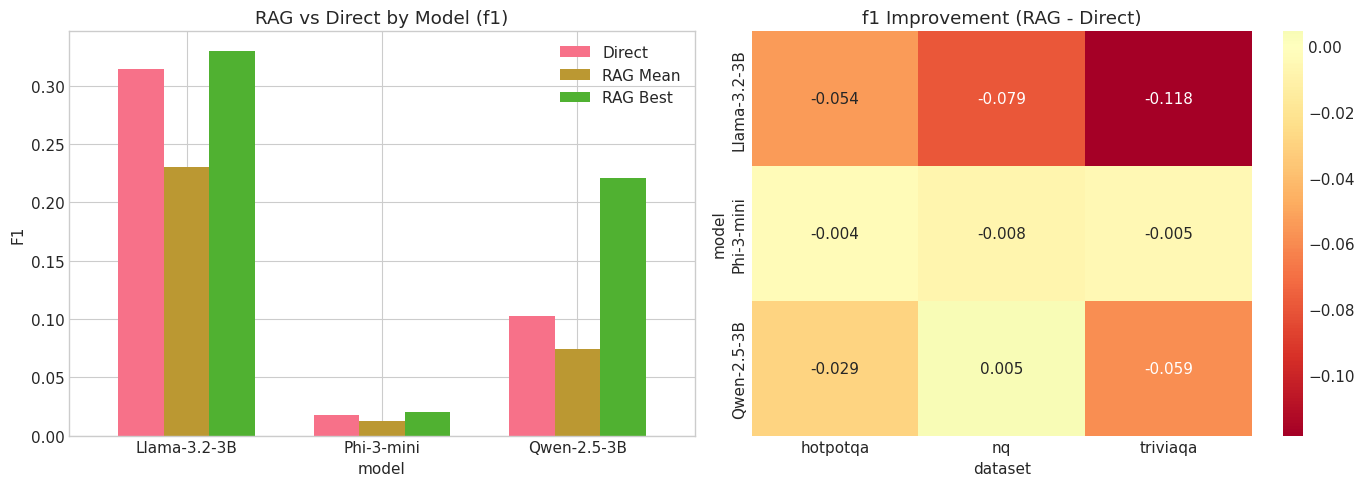

In [54]:
# RAG vs Direct by model and dataset
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    direct_df = df[df['exp_type'] == 'direct']
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(direct_df) > 0 and len(rag_df) > 0:
        comparisons = []
        for model in df['model_short'].dropna().unique():
            for dataset in df['dataset'].dropna().unique():
                direct_vals = direct_df[(direct_df['model_short'] == model) & 
                                        (direct_df['dataset'] == dataset)][PRIMARY_METRIC].dropna()
                rag_vals = rag_df[(rag_df['model_short'] == model) & 
                                  (rag_df['dataset'] == dataset)][PRIMARY_METRIC].dropna()
                
                if len(direct_vals) > 0 and len(rag_vals) > 0:
                    comparisons.append({
                        'model': model,
                        'dataset': dataset,
                        'direct': direct_vals.mean(),
                        'rag_mean': rag_vals.mean(),
                        'rag_best': rag_vals.max(),
                        'improvement': rag_vals.mean() - direct_vals.mean(),
                        'n_rag': len(rag_vals),
                    })
        
        if comparisons:
            comp_df = pd.DataFrame(comparisons)
            print("\nRAG vs Direct by Model × Dataset")
            display(comp_df.round(4))
            
            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Grouped bar by model
            model_comp = comp_df.groupby('model').agg({
                'direct': 'mean',
                'rag_mean': 'mean',
                'rag_best': 'mean',
            })
            model_comp.plot(kind='bar', ax=axes[0], width=0.7)
            axes[0].set_title(f'RAG vs Direct by Model ({PRIMARY_METRIC})')
            axes[0].set_ylabel(PRIMARY_METRIC.upper())
            axes[0].legend(['Direct', 'RAG Mean', 'RAG Best'])
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
            
            # Improvement heatmap
            pivot = comp_df.pivot(index='model', columns='dataset', values='improvement')
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=axes[1])
            axes[1].set_title(f'{PRIMARY_METRIC} Improvement (RAG - Direct)')
            
            plt.tight_layout()
            plt.show()

## 4. Component Effect Analysis

Analyze the marginal effect of each component while controlling for others.

In [55]:
def analyze_component_effects(
    df: pd.DataFrame,
    metric: str = PRIMARY_METRIC,
    components: List[str] = None,
    control_for: List[str] = ['model_short', 'dataset'],
) -> pd.DataFrame:
    """
    Analyze the effect of each RAG component on the metric.
    
    IMPORTANT: This now uses CONTROLLED analysis - effects are computed
    using marginal means that average across model/dataset strata.
    This removes confounding from these external factors.
    
    Args:
        df: DataFrame with experiment results
        metric: Metric to analyze
        components: RAG components to analyze (excluding confounders)
        control_for: Variables to control for (default: model, dataset)
    """
    if components is None:
        # Only RAG-specific components - NOT model/dataset
        components = ['retriever_type', 'embedding_model', 
                      'query_transform', 'reranker', 'prompt', 'top_k']
    
    rag_df = df[df['exp_type'] == 'rag'].copy()
    # Filter out unknown datasets
    rag_df = rag_df[rag_df['dataset'] != 'unknown']
    
    if metric not in rag_df.columns or len(rag_df) == 0:
        return pd.DataFrame()
    
    all_effects = []
    
    for comp in components:
        if comp not in rag_df.columns or comp in control_for:
            continue
        
        # Use the controlled analysis function
        controlled = analyze_factor_controlled(rag_df, comp, metric, control_for)
        if controlled.empty:
            continue
        
        # Find baseline
        baseline_row = controlled[controlled['is_baseline']]
        if baseline_row.empty:
            continue
        baseline_val = baseline_row[comp].iloc[0]
        baseline_mean = baseline_row['marginal_mean'].iloc[0]
        
        for _, row in controlled.iterrows():
            if row['is_baseline']:
                continue
            
            all_effects.append({
                'component': comp,
                'baseline': baseline_val,
                'treatment': row[comp],
                'baseline_mean': baseline_mean,
                'treatment_mean': row['marginal_mean'],
                'improvement': row['vs_baseline'],
                'pct_change': row['pct_change'],
                'effect_size': row['effect_size'],
                'p_value': row['p_value'],
                'significant': row['p_value'] < 0.05,
                'n_strata': row['n_strata'],
                'n_experiments': row['n'],
            })
    
    result = pd.DataFrame(all_effects)
    if not result.empty:
        result = result.sort_values('effect_size', ascending=False).reset_index(drop=True)
    return result


if len(df) > 0 and PRIMARY_METRIC in df.columns:
    effects_df = analyze_component_effects(df)
    if len(effects_df) > 0:
        print(f"RAG Component Effects on {PRIMARY_METRIC} (Controlled for Model/Dataset)")
        print("="*80)
        print("Effects computed using MARGINAL MEANS across model/dataset strata.")
        print("This removes confounding from these external factors.\n")
        print("Positive effect_size = treatment better than baseline\n")
        display(effects_df[['component', 'baseline', 'treatment', 'improvement', 
                           'pct_change', 'effect_size', 'p_value', 'significant', 
                           'n_strata', 'n_experiments']].round(4))

RAG Component Effects on f1 (Controlled for Model/Dataset)
Effects computed using MARGINAL MEANS across model/dataset strata.
This removes confounding from these external factors.

Positive effect_size = treatment better than baseline



,component,baseline,treatment,improvement,pct_change,effect_size,p_value,significant,n_strata,n_experiments
0,retriever_type,dense,hierarchical,0.0734,74.2256,0.7573,0.0310,True,7.0,10.0
1,prompt,concise,fewshot_3,0.0725,70.9936,0.6140,0.0259,True,9.0,19.0
2,top_k,3.0,5.0,0.0322,36.3868,0.1798,0.4267,False,9.0,39.0
3,reranker,none,bge-v2,0.0391,38.8508,-0.0124,0.9553,False,9.0,28.0
4,prompt,concise,structured,-0.0139,-13.6280,-0.0342,0.9034,False,7.0,17.0
5,top_k,3.0,10.0,-0.0193,-21.8231,-0.1203,0.6307,False,7.0,27.0
6,retriever_type,dense,hybrid,0.0119,12.0779,-0.1438,0.4891,False,8.0,40.0
7,query_transform,none,hyde,-0.0197,-18.5310,-0.2524,0.2624,False,9.0,36.0
8,embedding_model,BGE-large,BGE-M3,-0.0376,-30.6034,-0.2696,0.3251,False,9.0,19.0
9,embedding_model,BGE-large,GTE-Qwen2-1.5B,-0.0229,-18.6879,-0.2963,0.1721,False,9.0,40.0


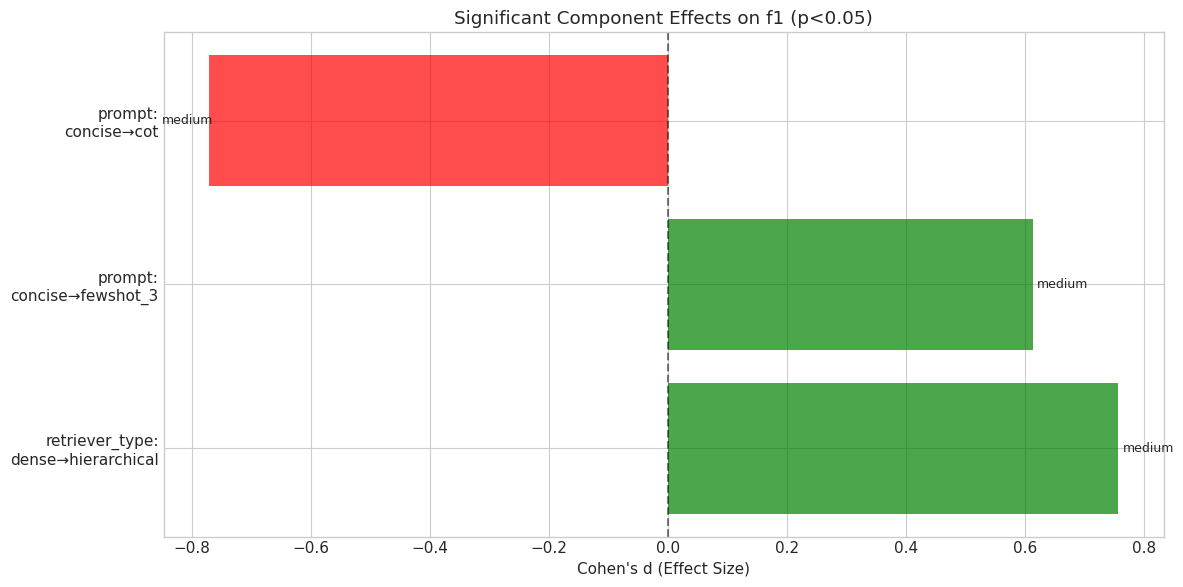

In [56]:
# Visualize component effects
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    effects_df = analyze_component_effects(df)
    if len(effects_df) > 0:
        # Filter to significant effects
        sig_effects = effects_df[effects_df['significant']].copy()
        
        if len(sig_effects) > 0:
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Create labels
            sig_effects['label'] = sig_effects.apply(
                lambda r: f"{r['component']}:\n{r['baseline']}→{r['treatment']}", axis=1
            )
            
            colors = ['green' if x > 0 else 'red' for x in sig_effects['effect_size']]
            
            bars = ax.barh(sig_effects['label'], sig_effects['effect_size'], color=colors, alpha=0.7)
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
            ax.set_xlabel("Cohen's d (Effect Size)")
            ax.set_title(f"Significant Component Effects on {PRIMARY_METRIC} (p<0.05)")
            
            # Add effect size labels
            for bar, es in zip(bars, sig_effects['effect_size']):
                width = bar.get_width()
                # Interpret effect size
                interp = 'negligible' if abs(es) < 0.2 else 'small' if abs(es) < 0.5 else 'medium' if abs(es) < 0.8 else 'large'
                ax.annotate(f'{interp}',
                           xy=(width, bar.get_y() + bar.get_height()/2),
                           xytext=(3, 0), textcoords='offset points',
                           ha='left' if width > 0 else 'right', va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        else:
            print("No statistically significant effects found (p<0.05)")

## 5. Model Comparison (with non-uniform weighting)

Model Comparison (weighted by dataset)


,model_short,mean,std,ci_low,ci_high,n,min,max
0,Llama-3.2-3B,0.2300,0.1522,0.1550,0.2532,39,0.0166,0.5492
1,Qwen-2.5-3B,0.0745,0.0911,0.0489,0.1061,38,0.0093,0.3517
2,Phi-3-mini,0.0099,0.0056,0.0088,0.0127,29,0.0049,0.0261


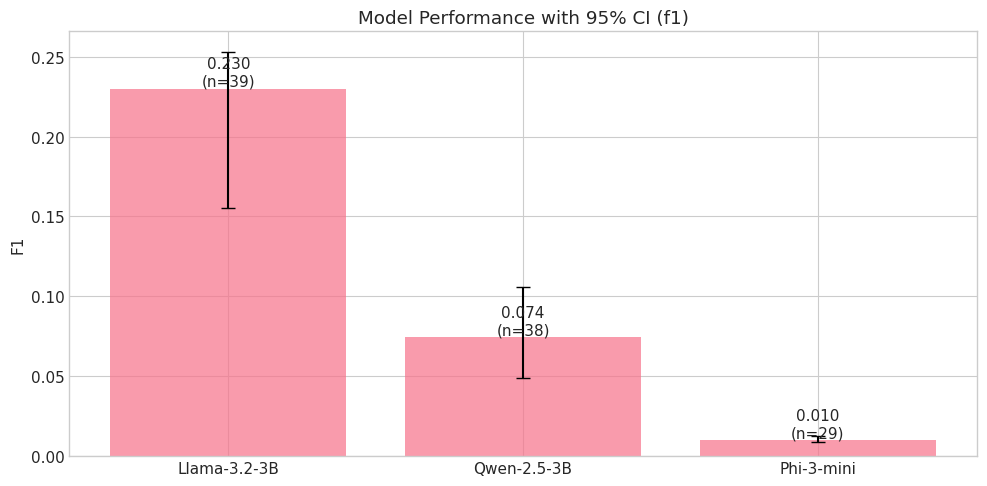

In [57]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(rag_df) > 0:
        # Weighted by dataset to account for non-uniform sampling
        model_stats = weighted_mean_with_ci(rag_df, 'model_short', PRIMARY_METRIC, weight_by='dataset')
        
        print(f"Model Comparison (weighted by dataset)")
        print("="*60)
        display(model_stats.round(4))
        
        # Visualize with error bars
        fig, ax = plt.subplots(figsize=(10, 5))
        
        x = range(len(model_stats))
        ax.bar(x, model_stats['mean'], 
               yerr=[model_stats['mean'] - model_stats['ci_low'], 
                     model_stats['ci_high'] - model_stats['mean']],
               capsize=5, alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(model_stats['model_short'])
        ax.set_ylabel(PRIMARY_METRIC.upper())
        ax.set_title(f'Model Performance with 95% CI ({PRIMARY_METRIC})')
        
        for i, row in model_stats.iterrows():
            ax.annotate(f"{row['mean']:.3f}\n(n={row['n']})",
                       xy=(i, row['mean']), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

## 5.5 Controlled RAG Analysis (Segmented by Model & Dataset)

Model and dataset are **confounding factors** for measuring RAG component effects.
Different models have different capabilities, and different datasets have different difficulties.

This section provides analysis **within each model-dataset combination** to isolate RAG-specific effects.

In [58]:
# Controlled analysis: RAG component effects within each model-dataset combination
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag'].copy()
    
    # Only analyze if we have non-unknown datasets
    rag_df_clean = rag_df[rag_df['dataset'] != 'unknown']
    
    if len(rag_df_clean) > 0:
        print("Controlled RAG Analysis (within Model × Dataset)")
        print("="*70)
        print("This removes model/dataset confounding to measure pure RAG effects.\n")
        
        # For each dataset, analyze RAG components
        for dataset in sorted(rag_df_clean['dataset'].unique()):
            ds_df = rag_df_clean[rag_df_clean['dataset'] == dataset]
            if len(ds_df) < 3:
                continue
            
            print(f"\n{'='*40}")
            print(f"Dataset: {dataset.upper()} (n={len(ds_df)} experiments)")
            print(f"{'='*40}")
            
            # For each RAG component, show effect within this dataset
            for comp in ['retriever_type', 'embedding_model', 'query_transform', 'reranker']:
                if comp not in ds_df.columns:
                    continue
                comp_vals = ds_df[comp].dropna().unique()
                if len(comp_vals) < 2:
                    continue
                    
                stats = ds_df.groupby(comp)[PRIMARY_METRIC].agg(['mean', 'std', 'count'])
                stats = stats.sort_values('mean', ascending=False)
                best = stats.index[0]
                best_val = stats.loc[best, 'mean']
                
                print(f"\n  {comp}:")
                for val in stats.index:
                    mean = stats.loc[val, 'mean']
                    n = stats.loc[val, 'count']
                    marker = ' ★' if val == best else ''
                    print(f"    {val}: {mean:.4f} (n={n}){marker}")
        
        # Summary: Best configuration per dataset
        print("\n" + "="*70)
        print("BEST CONFIGURATION PER DATASET")
        print("="*70)
        for dataset in sorted(rag_df_clean['dataset'].unique()):
            ds_df = rag_df_clean[rag_df_clean['dataset'] == dataset]
            if len(ds_df) == 0:
                continue
            best_idx = ds_df[PRIMARY_METRIC].idxmax()
            best = ds_df.loc[best_idx]
            print(f"\n{dataset}: {PRIMARY_METRIC}={best[PRIMARY_METRIC]:.4f}")
            print(f"  Retriever: {best.get('retriever_type', 'N/A')} / {best.get('embedding_model', 'N/A')}")
            print(f"  Query: {best.get('query_transform', 'none')}, Reranker: {best.get('reranker', 'none')}")

Controlled RAG Analysis (within Model × Dataset)
This removes model/dataset confounding to measure pure RAG effects.


Dataset: HOTPOTQA (n=41 experiments)

  retriever_type:
    hybrid: 0.0668 (n=18) ★
    dense: 0.0537 (n=19)
    hierarchical: 0.0189 (n=3)

  embedding_model:
    BGE-large: 0.0677 (n=17) ★
    GTE-Qwen2-1.5B: 0.0535 (n=18)
    BGE-M3: 0.0330 (n=5)

  query_transform:
    hyde: 0.0612 (n=14) ★
    none: 0.0571 (n=16)
    multiquery: 0.0510 (n=10)

  reranker:
    bge-v2: 0.0585 (n=15) ★
    none: 0.0561 (n=25)

Dataset: NQ (n=38 experiments)

  retriever_type:
    hierarchical: 0.1022 (n=3) ★
    dense: 0.0987 (n=20)
    hybrid: 0.0634 (n=14)

  embedding_model:
    BGE-M3: 0.1076 (n=8) ★
    BGE-large: 0.0818 (n=17)
    GTE-Qwen2-1.5B: 0.0763 (n=12)

  query_transform:
    hyde: 0.1248 (n=11) ★
    none: 0.0697 (n=16)
    multiquery: 0.0680 (n=10)

  reranker:
    bge-v2: 0.1215 (n=8) ★
    none: 0.0757 (n=29)

Dataset: TRIVIAQA (n=31 experiments)

  retriever_type:


## 6. Retrieval Strategy Comparison

In [59]:
# Controlled analysis - uses marginal means that average across model/dataset strata
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    # Filter out unknown datasets
    rag_df = rag_df[rag_df['dataset'] != 'unknown']
    
    print("CONTROLLED Retrieval Strategy Analysis")
    print("="*60)
    print("Using MARGINAL MEANS that average across model/dataset strata.")
    print("This removes confounding from these external factors.\n")
    
    for dimension in ['retriever_type', 'embedding_model', 'query_transform', 'reranker', 'prompt', 'top_k']:
        if dimension not in rag_df.columns:
            continue
        if rag_df[dimension].dropna().nunique() < 2:
            continue
        
        # Use controlled marginal means
        stats = compute_marginal_means(rag_df, dimension, PRIMARY_METRIC, control_vars=['model_short', 'dataset'])
        
        if len(stats) > 0:
            print(f"\n{dimension.replace('_', ' ').title()}")
            print("-"*50)
            display(stats.round(4))

CONTROLLED Retrieval Strategy Analysis
Using MARGINAL MEANS that average across model/dataset strata.
This removes confounding from these external factors.


Retriever Type
--------------------------------------------------


,retriever_type,marginal_mean,raw_mean,ci_low,ci_high,n_experiments,n_strata
0,hierarchical,0.1724,0.2087,0.0937,0.3339,10,7
1,hybrid,0.1109,0.0837,0.0543,0.1136,40,8
2,dense,0.0989,0.1010,0.0704,0.1350,56,9



Embedding Model
--------------------------------------------------


,embedding_model,marginal_mean,raw_mean,ci_low,ci_high,n_experiments,n_strata
0,BGE-large,0.1227,0.1271,0.0850,0.1749,47,9
1,GTE-Qwen2-1.5B,0.0998,0.0860,0.0555,0.1209,40,9
2,BGE-M3,0.0852,0.0883,0.0429,0.1346,19,9



Query Transform
--------------------------------------------------


,query_transform,marginal_mean,raw_mean,ci_low,ci_high,n_experiments,n_strata
0,multiquery,0.1304,0.0758,0.0417,0.1209,25,8
1,none,0.1062,0.1293,0.0860,0.1793,45,9
2,hyde,0.0865,0.0938,0.0617,0.1339,36,9



Reranker
--------------------------------------------------


,reranker,marginal_mean,raw_mean,ci_low,ci_high,n_experiments,n_strata
0,bge-v2,0.1398,0.1034,0.0639,0.1488,28,9
1,none,0.1007,0.1051,0.0766,0.1347,78,9



Prompt
--------------------------------------------------


,prompt,marginal_mean,raw_mean,ci_low,ci_high,n_experiments,n_strata
0,fewshot_3,0.1746,0.1957,0.1210,0.2837,19,9
1,concise,0.1021,0.1054,0.0738,0.1420,50,9
2,structured,0.0882,0.1012,0.0608,0.1431,17,7
3,cot,0.0191,0.0189,0.0166,0.0212,20,9



Top K
--------------------------------------------------


,top_k,marginal_mean,raw_mean,ci_low,ci_high,n_experiments,n_strata
0,5.0,0.1208,0.1248,0.0808,0.1785,39,9
1,3.0,0.0885,0.0986,0.0586,0.1417,40,9
2,10.0,0.0692,0.0844,0.0555,0.1186,27,7


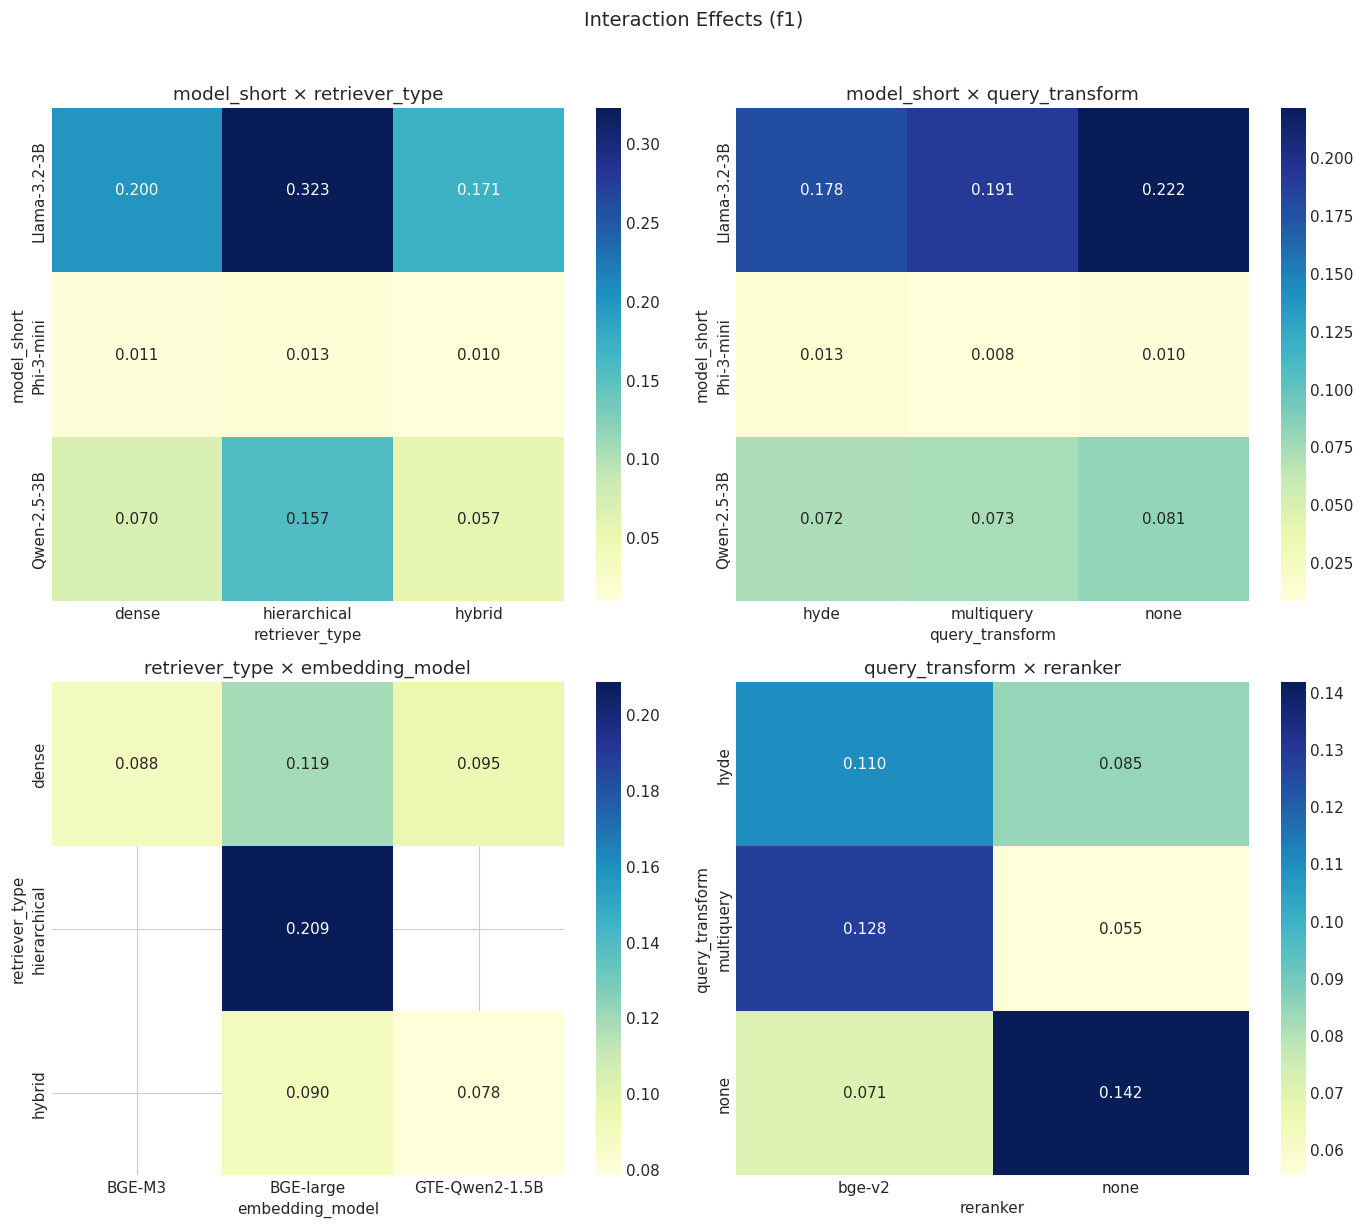

In [60]:
# Heatmaps for key interactions
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(rag_df) > 10:
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        interactions = [
            ('model_short', 'retriever_type'),
            ('model_short', 'query_transform'),
            ('retriever_type', 'embedding_model'),
            ('query_transform', 'reranker'),
        ]
        
        for ax, (row_dim, col_dim) in zip(axes.flatten(), interactions):
            if row_dim not in rag_df.columns or col_dim not in rag_df.columns:
                ax.set_visible(False)
                continue
            
            pivot = rag_df.pivot_table(
                index=row_dim, columns=col_dim, values=PRIMARY_METRIC, aggfunc='mean'
            )
            
            if pivot.empty:
                ax.set_visible(False)
                continue
            
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
            ax.set_title(f'{row_dim} × {col_dim}')
        
        plt.suptitle(f'Interaction Effects ({PRIMARY_METRIC})', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

## 7. Prompt Strategy Analysis

Prompt Strategy Comparison


,prompt,mean,std,ci_low,ci_high,n,min,max
0,fewshot_3,0.1757,0.1754,0.1238,0.2553,28,0.0049,0.5664
1,concise,0.1162,0.1334,0.0778,0.1439,59,0.0063,0.4912
2,structured,0.1079,0.0854,0.0578,0.1423,17,0.0077,0.2502
3,cot,0.0177,0.0055,0.0166,0.0214,20,0.0093,0.0333


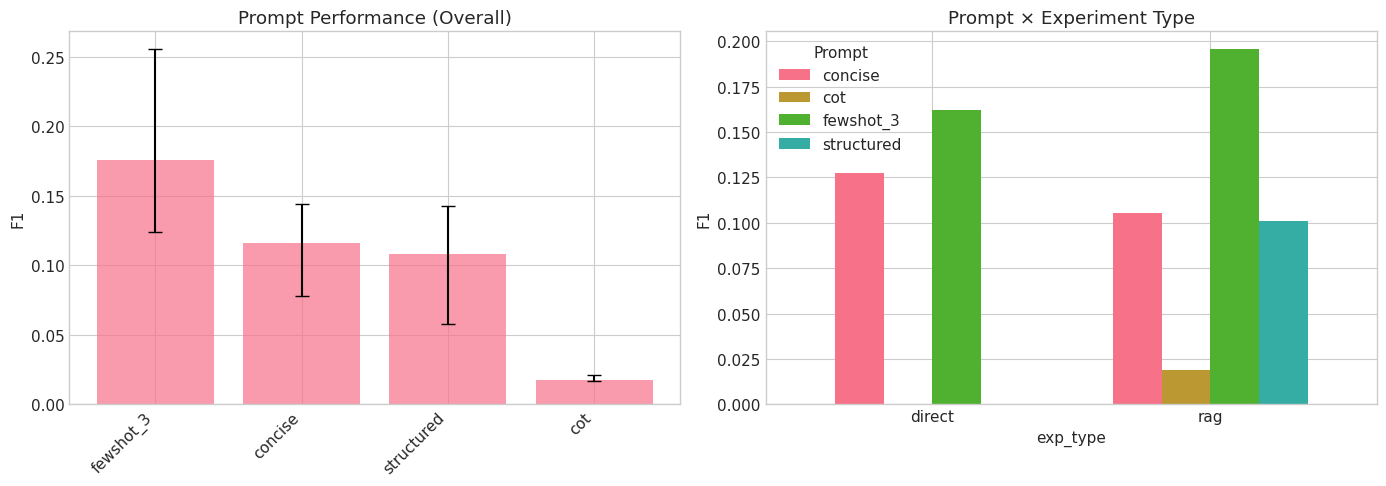

In [61]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    # Combine direct and RAG for prompt analysis
    prompt_stats = weighted_mean_with_ci(df, 'prompt', PRIMARY_METRIC, weight_by='dataset')
    
    if len(prompt_stats) > 0:
        print("Prompt Strategy Comparison")
        print("="*60)
        display(prompt_stats.round(4))
        
        # By experiment type
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Overall
        ax = axes[0]
        ax.bar(prompt_stats['prompt'], prompt_stats['mean'],
               yerr=[prompt_stats['mean'] - prompt_stats['ci_low'],
                     prompt_stats['ci_high'] - prompt_stats['mean']],
               capsize=5, alpha=0.7)
        ax.set_ylabel(PRIMARY_METRIC.upper())
        ax.set_title('Prompt Performance (Overall)')
        ax.set_xticklabels(prompt_stats['prompt'], rotation=45, ha='right')
        
        # By type (Direct vs RAG)
        ax = axes[1]
        type_prompt = df.groupby(['exp_type', 'prompt'])[PRIMARY_METRIC].mean().unstack()
        type_prompt.plot(kind='bar', ax=ax, width=0.7)
        ax.set_ylabel(PRIMARY_METRIC.upper())
        ax.set_title('Prompt × Experiment Type')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend(title='Prompt')
        
        plt.tight_layout()
        plt.show()

Prompt Effect by Model
Shows how each prompt performs for each model (averaging across datasets).


Llama-3.2-3B:
  fewshot_3: 0.3540 (n=6) ★ BEST
  concise: 0.2384 (n=19)
  structured: 0.1780 (n=6)
  cot: 0.0207 (n=8)

Phi-3-mini:
  cot: 0.0195 (n=6) ★ BEST
  structured: 0.0095 (n=5)
  concise: 0.0086 (n=12)
  fewshot_3: 0.0072 (n=6)

Qwen-2.5-3B:
  fewshot_3: 0.2217 (n=7) ★ BEST
  structured: 0.1009 (n=6)
  concise: 0.0336 (n=19)
  cot: 0.0160 (n=6)


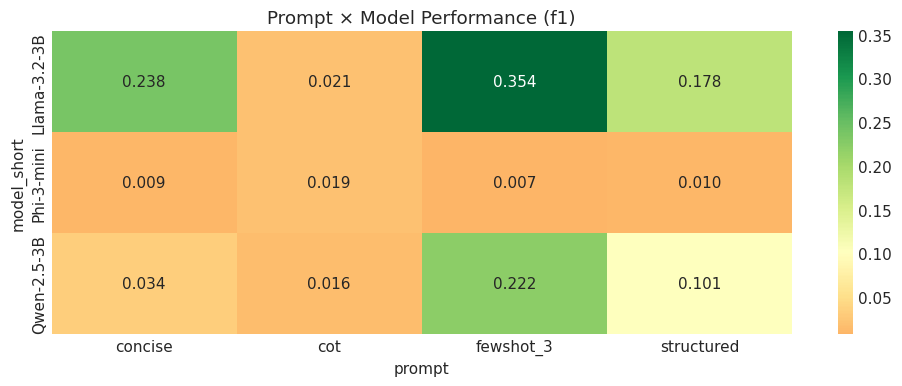


Prompt Effect by Model and Dataset (Detailed)

HOTPOTQA:
  Llama-3.2-3B: best=fewshot_3 (0.1767)
  Phi-3-mini: best=cot (0.0138)
  Qwen-2.5-3B: best=fewshot_3 (0.0912)

NQ:
  Llama-3.2-3B: best=fewshot_3 (0.2612)
  Phi-3-mini: best=cot (0.0170)
  Qwen-2.5-3B: best=fewshot_3 (0.1759)

TRIVIAQA:
  Llama-3.2-3B: best=fewshot_3 (0.5031)
  Phi-3-mini: best=cot (0.0260)
  Qwen-2.5-3B: best=fewshot_3 (0.3392)


In [62]:
# Prompt Effect Per Model (and per Dataset)
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[(df['exp_type'] == 'rag') & (df['dataset'] != 'unknown')]
    
    print("Prompt Effect by Model")
    print("="*70)
    print("Shows how each prompt performs for each model (averaging across datasets).\n")
    
    # Create a pivot table: rows=model, cols=prompt, values=mean metric
    if 'prompt' in rag_df.columns and 'model_short' in rag_df.columns:
        prompt_by_model = rag_df.groupby(['model_short', 'prompt'])[PRIMARY_METRIC].agg(['mean', 'count'])
        prompt_by_model = prompt_by_model.unstack(level=1)
        
        # Print for each model
        for model in sorted(rag_df['model_short'].unique()):
            model_df = rag_df[rag_df['model_short'] == model]
            if len(model_df) < 3:
                continue
            
            print(f"\n{model}:")
            prompt_stats = model_df.groupby('prompt')[PRIMARY_METRIC].agg(['mean', 'std', 'count'])
            prompt_stats = prompt_stats.sort_values('mean', ascending=False)
            best_prompt = prompt_stats.index[0]
            
            for prompt in prompt_stats.index:
                mean = prompt_stats.loc[prompt, 'mean']
                n = prompt_stats.loc[prompt, 'count']
                marker = ' ★ BEST' if prompt == best_prompt else ''
                print(f"  {prompt}: {mean:.4f} (n={n}){marker}")
        
        # Visualization: heatmap of prompt × model
        pivot = rag_df.pivot_table(values=PRIMARY_METRIC, index='model_short', columns='prompt', aggfunc='mean')
        if not pivot.empty:
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=pivot.values.mean())
            plt.title(f'Prompt × Model Performance ({PRIMARY_METRIC})')
            plt.tight_layout()
            plt.show()
    
    # Optional: Prompt × Model × Dataset breakdown
    print("\n" + "="*70)
    print("Prompt Effect by Model and Dataset (Detailed)")
    print("="*70)
    
    for dataset in sorted(rag_df['dataset'].unique()):
        ds_df = rag_df[rag_df['dataset'] == dataset]
        if len(ds_df) < 3:
            continue
        
        print(f"\n{dataset.upper()}:")
        for model in sorted(ds_df['model_short'].unique()):
            model_df = ds_df[ds_df['model_short'] == model]
            if len(model_df) < 2:
                continue
            
            prompt_perf = model_df.groupby('prompt')[PRIMARY_METRIC].mean().sort_values(ascending=False)
            best = prompt_perf.index[0]
            best_val = prompt_perf.iloc[0]
            print(f"  {model}: best={best} ({best_val:.4f})")

## 8. Dataset-Specific Analysis

In [63]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    
    print("Best Configurations per Dataset")
    print("="*60)
    
    for dataset in df['dataset'].dropna().unique():
        ds_df = rag_df[rag_df['dataset'] == dataset]
        if len(ds_df) == 0:
            continue
        
        best_idx = ds_df[PRIMARY_METRIC].idxmax()
        best = ds_df.loc[best_idx]
        
        print(f"\n{dataset.upper()}:")
        print(f"  Best {PRIMARY_METRIC}: {best[PRIMARY_METRIC]:.4f}")
        print(f"  Model: {best['model_short']}")
        print(f"  Retriever: {best.get('retriever_type', 'N/A')}")
        print(f"  Embedding: {best.get('embedding_model', 'N/A')}")
        print(f"  Query transform: {best.get('query_transform', 'none')}")
        print(f"  Reranker: {best.get('reranker', 'none')}")
        print(f"  Prompt: {best.get('prompt', 'N/A')}")

Best Configurations per Dataset

HOTPOTQA:
  Best f1: 0.1805
  Model: Llama-3.2-3B
  Retriever: hybrid
  Embedding: BGE-large
  Query transform: none
  Reranker: none
  Prompt: fewshot_3

NQ:
  Best f1: 0.2612
  Model: Llama-3.2-3B
  Retriever: dense
  Embedding: BGE-M3
  Query transform: hyde
  Reranker: bge-v2
  Prompt: fewshot_3

TRIVIAQA:
  Best f1: 0.5492
  Model: Llama-3.2-3B
  Retriever: hierarchical
  Embedding: BGE-large
  Query transform: none
  Reranker: none
  Prompt: fewshot_3


In [64]:
# Dataset difficulty comparison
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    dataset_stats = weighted_mean_with_ci(df, 'dataset', PRIMARY_METRIC)
    
    print("\nDataset Difficulty (lower = harder)")
    print("="*60)
    display(dataset_stats.round(4))
    
    # Which strategies work best on hardest dataset?
    hardest = dataset_stats.iloc[-1]['dataset']
    print(f"\nStrategies on hardest dataset ({hardest}):")
    
    rag_df = df[(df['exp_type'] == 'rag') & (df['dataset'] == hardest)]
    if len(rag_df) > 0:
        for comp in ['retriever_type', 'query_transform', 'reranker']:
            if comp in rag_df.columns:
                stats = rag_df.groupby(comp)[PRIMARY_METRIC].mean().sort_values(ascending=False)
                best = stats.index[0]
                print(f"  Best {comp}: {best} ({stats.iloc[0]:.4f})")


Dataset Difficulty (lower = harder)


,dataset,mean,std,ci_low,ci_high,n,min,max
0,triviaqa,0.2033,0.1947,0.1388,0.2712,35,0.0127,0.5664
1,nq,0.0888,0.1018,0.0601,0.1183,43,0.0068,0.2612
2,hotpotqa,0.0600,0.0568,0.0447,0.0766,46,0.0049,0.1995



Strategies on hardest dataset (hotpotqa):
  Best retriever_type: hybrid (0.0668)
  Best query_transform: hyde (0.0612)
  Best reranker: bge-v2 (0.0585)


## 9. Bottleneck Identification

In [65]:
def identify_bottlenecks(df: pd.DataFrame, metric: str = PRIMARY_METRIC) -> Dict[str, Any]:
    """
    Identify bottlenecks in the RAG pipeline.
    
    Returns analysis of where improvements would have biggest impact.
    """
    rag_df = df[df['exp_type'] == 'rag'].copy()
    if len(rag_df) < 10:
        return {}
    
    # Compute variance explained by each component
    total_var = rag_df[metric].var()
    
    variance_explained = {}
    components = ['model_short', 'retriever_type', 'embedding_model', 
                  'query_transform', 'reranker', 'prompt', 'top_k', 'dataset']
    
    for comp in components:
        if comp not in rag_df.columns:
            continue
        if rag_df[comp].dropna().nunique() < 2:
            continue
        
        # Between-group variance
        group_means = rag_df.groupby(comp)[metric].mean()
        grand_mean = rag_df[metric].mean()
        group_sizes = rag_df.groupby(comp).size()
        
        ss_between = sum(group_sizes[g] * (group_means[g] - grand_mean)**2 
                        for g in group_means.index)
        
        variance_explained[comp] = ss_between / (total_var * len(rag_df)) if total_var > 0 else 0
    
    # Sort by impact
    sorted_components = sorted(variance_explained.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'variance_explained': dict(sorted_components),
        'top_bottleneck': sorted_components[0][0] if sorted_components else None,
        'total_experiments': len(rag_df),
    }


if len(df) > 0 and PRIMARY_METRIC in df.columns:
    bottlenecks = identify_bottlenecks(df)
    
    if bottlenecks:
        print("Bottleneck Analysis (Variance Explained)")
        print("="*60)
        print("Higher = more impact on performance variance\n")
        
        var_exp = bottlenecks['variance_explained']
        for comp, var in var_exp.items():
            bar = '█' * int(var * 50)
            print(f"{comp:20s} {var:6.1%} {bar}")
        
        print(f"\n🎯 Top bottleneck: {bottlenecks['top_bottleneck']}")
        print("   → Focus optimization efforts here for biggest gains")

Bottleneck Analysis (Variance Explained)
Higher = more impact on performance variance

model_short           35.3% █████████████████
dataset               18.2% █████████
prompt                16.3% ████████
retriever_type         8.6% ████
query_transform        2.8% █
embedding_model        2.3% █
top_k                  1.5% 
reranker               0.0% 

🎯 Top bottleneck: model_short
   → Focus optimization efforts here for biggest gains


## 10. Recommendations

In [66]:
def generate_recommendations(df: pd.DataFrame, metric: str = PRIMARY_METRIC):
    """Generate actionable recommendations based on analysis."""
    print("="*70)
    print("📋 RECOMMENDATIONS")
    print("="*70)
    
    rag_df = df[df['exp_type'] == 'rag']
    direct_df = df[df['exp_type'] == 'direct']
    
    if len(rag_df) == 0:
        print("Insufficient RAG experiments for recommendations.")
        return
    
    # 1. Best overall
    best_idx = rag_df[metric].idxmax()
    best = rag_df.loc[best_idx]
    print(f"\n1. BEST OVERALL CONFIGURATION ({metric}={best[metric]:.4f})")
    print(f"   Model: {best['model_short']}")
    print(f"   Retriever: {best.get('retriever_type', 'N/A')} / {best.get('embedding_model', 'N/A')}")
    print(f"   Query: {best.get('query_transform', 'none')}, Reranker: {best.get('reranker', 'none')}")
    print(f"   Prompt: {best.get('prompt', 'N/A')}, top_k: {best.get('top_k', 'N/A')}")
    
    # 2. Component recommendations
    effects_df = analyze_component_effects(df, metric)
    if len(effects_df) > 0:
        sig_positive = effects_df[(effects_df['significant']) & (effects_df['improvement'] > 0)]
        if len(sig_positive) > 0:
            print(f"\n2. SIGNIFICANT IMPROVEMENTS (p<0.05)")
            for _, row in sig_positive.head(5).iterrows():
                print(f"   ✓ {row['component']}: {row['baseline']} → {row['treatment']}")
                interp = 'negligible' if abs(row['effect_size']) < 0.2 else 'small' if abs(row['effect_size']) < 0.5 else 'medium' if abs(row['effect_size']) < 0.8 else 'large'
                print(f"     Effect: {row['improvement']:+.4f} ({interp})")
    
    # 3. Bottleneck
    bottlenecks = identify_bottlenecks(df, metric)
    if bottlenecks and bottlenecks['top_bottleneck']:
        print(f"\n3. PRIORITY FOR OPTIMIZATION")
        print(f"   Focus on: {bottlenecks['top_bottleneck']}")
        var = bottlenecks['variance_explained'].get(bottlenecks['top_bottleneck'], 0)
        print(f"   Explains {var:.1%} of performance variance")
    
    # 4. Dataset-specific
    print(f"\n4. DATASET-SPECIFIC INSIGHTS")
    for dataset in df['dataset'].dropna().unique():
        ds_rag = rag_df[rag_df['dataset'] == dataset]
        ds_direct = direct_df[direct_df['dataset'] == dataset]
        
        if len(ds_rag) > 0 and len(ds_direct) > 0:
            rag_best = ds_rag[metric].max()
            direct_best = ds_direct[metric].max()
            improvement = (rag_best - direct_best) / direct_best * 100 if direct_best > 0 else 0
            print(f"   {dataset}: RAG improves by {improvement:+.1f}% over direct")
    
    # 5. Quick wins
    print(f"\n5. QUICK WINS (low complexity, positive effect)")
    quick_wins = [
        ('prompt', 'Try structured or cot prompts'),
        ('reranker', 'Add bge-v2 reranker'),
        ('query_transform', 'Enable HyDE'),
    ]
    for comp, desc in quick_wins:
        if comp in effects_df['component'].values:
            comp_effects = effects_df[effects_df['component'] == comp]
            best_effect = comp_effects.iloc[0] if len(comp_effects) > 0 else None
            if best_effect is not None and best_effect['improvement'] > 0:
                print(f"   ✓ {desc}: +{best_effect['improvement']:.4f} {metric}")


if len(df) > 0 and PRIMARY_METRIC in df.columns:
    generate_recommendations(df)

📋 RECOMMENDATIONS

1. BEST OVERALL CONFIGURATION (f1=0.5492)
   Model: Llama-3.2-3B
   Retriever: hierarchical / BGE-large
   Query: none, Reranker: none
   Prompt: fewshot_3, top_k: 5.0

2. SIGNIFICANT IMPROVEMENTS (p<0.05)
   ✓ retriever_type: dense → hierarchical
     Effect: +0.0734 (medium)
   ✓ prompt: concise → fewshot_3
     Effect: +0.0725 (medium)

3. PRIORITY FOR OPTIMIZATION
   Focus on: model_short
   Explains 35.3% of performance variance

4. DATASET-SPECIFIC INSIGHTS
   hotpotqa: RAG improves by -9.5% over direct
   nq: RAG improves by +0.2% over direct
   triviaqa: RAG improves by -3.1% over direct

5. QUICK WINS (low complexity, positive effect)
   ✓ Try structured or cot prompts: +0.0725 f1
   ✓ Add bge-v2 reranker: +0.0391 f1


## 11. Export Analysis Results

In [67]:
if len(df) > 0:
    output_dir = STUDY_PATH / "analysis"
    output_dir.mkdir(exist_ok=True)
    
    # Full results
    df.to_csv(output_dir / "full_results.csv", index=False)
    
    # Component effects
    if PRIMARY_METRIC in df.columns:
        effects_df = analyze_component_effects(df)
        if len(effects_df) > 0:
            effects_df.to_csv(output_dir / "component_effects.csv", index=False)
    
    # Bottleneck analysis
    bottlenecks = identify_bottlenecks(df)
    if bottlenecks:
        with open(output_dir / "bottleneck_analysis.json", 'w') as f:
            json.dump(bottlenecks, f, indent=2)
    
    print(f"Results exported to: {output_dir}")

Results exported to: ../outputs/smart_retrieval_slm/analysis


## 12. Multi-Metric Comparison

Analyze performance across all available metrics to understand if findings are consistent.

In [ ]:
def multi_metric_comparison(df: pd.DataFrame, metrics: List[str] = None) -> pd.DataFrame:
    """
    Compare performance across multiple metrics for RAG vs Direct.
    
    Returns a DataFrame with mean, std, and statistical comparisons for each metric.
    """
    if metrics is None:
        metrics = [m for m in METRICS if m in df.columns and df[m].notna().sum() > 0]
    
    results = []
    
    rag_df = df[df['exp_type'] == 'rag']
    direct_df = df[df['exp_type'] == 'direct']
    
    for metric in metrics:
        if metric not in df.columns:
            continue
            
        rag_vals = rag_df[metric].dropna()
        direct_vals = direct_df[metric].dropna()
        
        if len(rag_vals) < 2 or len(direct_vals) < 2:
            continue
        
        # Compute effect size and p-value
        es, pval, interp = effect_size(direct_vals.values, rag_vals.values)
        
        results.append({
            'metric': metric,
            'rag_mean': rag_vals.mean(),
            'rag_std': rag_vals.std(),
            'rag_max': rag_vals.max(),
            'direct_mean': direct_vals.mean(),
            'direct_std': direct_vals.std(),
            'direct_max': direct_vals.max(),
            'delta': rag_vals.mean() - direct_vals.mean(),
            'pct_change': (rag_vals.mean() - direct_vals.mean()) / direct_vals.mean() * 100 if direct_vals.mean() != 0 else 0,
            'effect_size': es,
            'interpretation': interp,
            'p_value': pval,
            'n_rag': len(rag_vals),
            'n_direct': len(direct_vals),
        })
    
    return pd.DataFrame(results)


if len(df) > 0:
    available_metrics = [m for m in METRICS if m in df.columns and df[m].notna().sum() > 0]
    
    if len(available_metrics) > 0:
        print("Multi-Metric RAG vs Direct Comparison")
        print("=" * 70)
        
        metrics_df = multi_metric_comparison(df, available_metrics)
        display(metrics_df.round(4))
        
        # Visualization: Multi-metric comparison
        if len(metrics_df) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Plot 1: Mean comparison with confidence intervals
            ax1 = axes[0]
            x = np.arange(len(metrics_df))
            width = 0.35
            
            ax1.bar(x - width/2, metrics_df['direct_mean'], width, label='Direct', 
                    color='steelblue', alpha=0.8, yerr=metrics_df['direct_std'], capsize=3)
            ax1.bar(x + width/2, metrics_df['rag_mean'], width, label='RAG', 
                    color='coral', alpha=0.8, yerr=metrics_df['rag_std'], capsize=3)
            
            ax1.set_xlabel('Metric')
            ax1.set_ylabel('Score')
            ax1.set_title('Direct vs RAG: Mean Performance')
            ax1.set_xticks(x)
            ax1.set_xticklabels(metrics_df['metric'], rotation=45, ha='right')
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)
            
            # Plot 2: Effect sizes
            ax2 = axes[1]
            colors = ['green' if es > 0 else 'red' for es in metrics_df['effect_size']]
            bars = ax2.barh(metrics_df['metric'], metrics_df['effect_size'], color=colors, alpha=0.7)
            
            # Add significance markers
            for i, (es, pval) in enumerate(zip(metrics_df['effect_size'], metrics_df['p_value'])):
                marker = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                ax2.text(es + 0.02 if es >= 0 else es - 0.05, i, marker, va='center', fontsize=12)
            
            ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            ax2.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
            ax2.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
            ax2.set_xlabel("Cohen's d Effect Size (RAG vs Direct)")
            ax2.set_title('Effect Size by Metric (* p<0.05, ** p<0.01, *** p<0.001)')
            ax2.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # Summary
        print("\nMetric Correlation Analysis:")
        metric_cols = [m for m in available_metrics if m in df.columns]
        if len(metric_cols) > 1:
            corr_matrix = df[metric_cols].corr()
            print("Pairwise correlations between metrics:")
            display(corr_matrix.round(3))
    else:
        print("No metrics available for multi-metric comparison.")

## 13. Component Interaction Analysis

Analyze how RAG components interact with each other. Some combinations may be synergistic or redundant.

In [ ]:
def analyze_interactions(df: pd.DataFrame, factor1: str, factor2: str, 
                         metric: str = PRIMARY_METRIC) -> pd.DataFrame:
    """
    Analyze interaction effects between two RAG components.
    
    Returns a pivot table showing mean performance for each combination,
    along with interaction statistics.
    """
    rag_df = df[df['exp_type'] == 'rag'].copy()
    
    if factor1 not in rag_df.columns or factor2 not in rag_df.columns:
        return None
    
    # Compute mean for each combination
    interaction = rag_df.groupby([factor1, factor2])[metric].agg(['mean', 'std', 'count']).reset_index()
    interaction.columns = [factor1, factor2, 'mean', 'std', 'count']
    
    # Create pivot table
    pivot = interaction.pivot(index=factor1, columns=factor2, values='mean')
    
    return pivot, interaction


def plot_interaction_heatmap(df: pd.DataFrame, factor1: str, factor2: str, 
                              metric: str = PRIMARY_METRIC, ax=None) -> None:
    """Plot a heatmap showing interaction between two factors."""
    result = analyze_interactions(df, factor1, factor2, metric)
    if result is None:
        return
    
    pivot, _ = result
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                center=pivot.values.mean(), ax=ax)
    ax.set_title(f'{factor1} × {factor2} Interaction\n(Mean {metric})')
    ax.set_xlabel(factor2)
    ax.set_ylabel(factor1)


def find_synergistic_combinations(df: pd.DataFrame, factor1: str, factor2: str,
                                   metric: str = PRIMARY_METRIC) -> List[dict]:
    """
    Identify synergistic and redundant component combinations.
    
    A combination is synergistic if performance is better than expected from
    individual component effects (positive interaction).
    """
    rag_df = df[df['exp_type'] == 'rag'].copy()
    
    if factor1 not in rag_df.columns or factor2 not in rag_df.columns:
        return []
    
    # Overall mean
    overall_mean = rag_df[metric].mean()
    
    # Marginal effects for each factor
    f1_means = rag_df.groupby(factor1)[metric].mean()
    f2_means = rag_df.groupby(factor2)[metric].mean()
    
    # Actual combination means
    combo_means = rag_df.groupby([factor1, factor2])[metric].mean()
    
    results = []
    for (v1, v2), actual in combo_means.items():
        expected = overall_mean + (f1_means[v1] - overall_mean) + (f2_means[v2] - overall_mean)
        interaction_effect = actual - expected
        
        results.append({
            factor1: v1,
            factor2: v2,
            'actual': actual,
            'expected': expected,
            'interaction_effect': interaction_effect,
            'synergy': 'Synergistic' if interaction_effect > 0.01 else 
                       'Redundant' if interaction_effect < -0.01 else 'Neutral'
        })
    
    return sorted(results, key=lambda x: x['interaction_effect'], reverse=True)


# Key component interactions to analyze
interactions_to_analyze = [
    ('retriever_type', 'reranker'),
    ('retriever_type', 'embedding_model'),
    ('reranker', 'query_transform'),
    ('prompt', 'model_short'),
    ('top_k', 'retriever_type'),
]

rag_df = df[df['exp_type'] == 'rag']
if len(rag_df) > 10:
    print("Component Interaction Analysis")
    print("=" * 70)
    
    # Filter to interactions that have data
    valid_interactions = []
    for f1, f2 in interactions_to_analyze:
        if f1 in rag_df.columns and f2 in rag_df.columns:
            n_combos = rag_df.groupby([f1, f2]).size()
            if len(n_combos) > 2:
                valid_interactions.append((f1, f2))
    
    if valid_interactions:
        # Plot heatmaps for top interactions
        n_plots = min(len(valid_interactions), 4)
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        
        for i, (f1, f2) in enumerate(valid_interactions[:n_plots]):
            plot_interaction_heatmap(df, f1, f2, ax=axes[i])
        
        # Hide unused subplots
        for i in range(n_plots, 4):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Find synergistic combinations
        print("\nSynergistic and Redundant Combinations:")
        print("-" * 70)
        
        for f1, f2 in valid_interactions[:3]:
            synergies = find_synergistic_combinations(df, f1, f2)
            if synergies:
                print(f"\n{f1} × {f2}:")
                top_synergistic = [s for s in synergies if s['synergy'] == 'Synergistic'][:3]
                top_redundant = [s for s in synergies if s['synergy'] == 'Redundant'][:3]
                
                if top_synergistic:
                    print("  Top Synergistic (better than expected):")
                    for s in top_synergistic:
                        print(f"    - {s[f1]} + {s[f2]}: {s['actual']:.3f} (expected {s['expected']:.3f}, +{s['interaction_effect']:.3f})")
                
                if top_redundant:
                    print("  Top Redundant (worse than expected):")
                    for s in top_redundant:
                        print(f"    - {s[f1]} + {s[f2]}: {s['actual']:.3f} (expected {s['expected']:.3f}, {s['interaction_effect']:.3f})")
    else:
        print("Insufficient data for interaction analysis.")
else:
    print("Not enough RAG experiments for interaction analysis.")

## 14. Statistical Robustness Analysis

Validate the reliability of our findings through power analysis and sensitivity checks.

In [ ]:
def compute_power_analysis(df: pd.DataFrame, factor: str, metric: str = PRIMARY_METRIC,
                            alpha: float = 0.05, min_power: float = 0.8) -> dict:
    """
    Compute statistical power for detecting effects in each factor level.
    
    Returns power estimates and minimum detectable effect sizes.
    """
    rag_df = df[df['exp_type'] == 'rag']
    
    if factor not in rag_df.columns:
        return {}
    
    groups = rag_df.groupby(factor)[metric]
    overall_std = rag_df[metric].std()
    
    results = {}
    for name, group in groups:
        n = len(group)
        if n < 2:
            continue
        
        # Standard error
        se = group.std() / np.sqrt(n)
        
        # Minimum detectable effect (at 80% power, simplified approximation)
        # MDE ≈ 2.8 * SE (for two-sided test, alpha=0.05, power=0.80)
        mde = 2.8 * se if se > 0 else float('inf')
        
        # Effect size that could be detected (Cohen's d)
        min_d = mde / overall_std if overall_std > 0 else float('inf')
        
        results[name] = {
            'n': n,
            'mean': group.mean(),
            'std': group.std(),
            'se': se,
            'mde': mde,
            'min_cohens_d': min_d,
            'adequate_power': min_d < 0.5  # Can detect medium effects
        }
    
    return results


def sensitivity_analysis(df: pd.DataFrame, factor: str, metric: str = PRIMARY_METRIC,
                          n_bootstrap: int = 100) -> pd.DataFrame:
    """
    Perform sensitivity analysis by bootstrapping to check stability of rankings.
    """
    rag_df = df[df['exp_type'] == 'rag']
    
    if factor not in rag_df.columns:
        return None
    
    # Get original ranking
    original_means = rag_df.groupby(factor)[metric].mean().sort_values(ascending=False)
    original_rank = {v: i for i, v in enumerate(original_means.index)}
    
    # Bootstrap rankings
    rank_counts = defaultdict(lambda: defaultdict(int))
    
    for _ in range(n_bootstrap):
        sample = rag_df.sample(frac=1.0, replace=True)
        boot_means = sample.groupby(factor)[metric].mean().sort_values(ascending=False)
        
        for rank, value in enumerate(boot_means.index):
            rank_counts[value][rank] += 1
    
    # Compile results
    results = []
    for value in original_means.index:
        ranks = rank_counts[value]
        most_common_rank = max(ranks.keys(), key=lambda r: ranks[r])
        rank_stability = ranks[most_common_rank] / n_bootstrap
        
        results.append({
            factor: value,
            'original_mean': original_means[value],
            'original_rank': original_rank[value] + 1,
            'most_common_rank': most_common_rank + 1,
            'rank_stability': rank_stability,
            'rank_range': (min(ranks.keys()) + 1, max(ranks.keys()) + 1)
        })
    
    return pd.DataFrame(results)


if len(df) > 0:
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(rag_df) > 10:
        print("Statistical Robustness Analysis")
        print("=" * 70)
        
        # Power analysis for key factors
        key_factors = ['retriever_type', 'embedding_model', 'reranker', 'prompt']
        available_factors = [f for f in key_factors if f in rag_df.columns and rag_df[f].nunique() > 1]
        
        if available_factors:
            print("\n1. POWER ANALYSIS")
            print("-" * 50)
            print("Assessing whether sample sizes are adequate to detect meaningful effects.\n")
            
            power_summary = []
            for factor in available_factors:
                power = compute_power_analysis(df, factor)
                n_adequate = sum(1 for v in power.values() if v.get('adequate_power', False))
                n_total = len(power)
                power_summary.append({
                    'factor': factor,
                    'n_levels': n_total,
                    'adequate_power': n_adequate,
                    'pct_adequate': n_adequate / n_total * 100 if n_total > 0 else 0,
                    'avg_n': np.mean([v['n'] for v in power.values()]) if power else 0
                })
            
            power_df = pd.DataFrame(power_summary)
            display(power_df.round(1))
            
            # Sensitivity analysis for top factor
            print("\n2. SENSITIVITY ANALYSIS (Bootstrap Stability)")
            print("-" * 50)
            print("Checking if component rankings are stable under resampling.\n")
            
            for factor in available_factors[:2]:
                print(f"\n{factor}:")
                sensitivity = sensitivity_analysis(df, factor, n_bootstrap=100)
                if sensitivity is not None and len(sensitivity) > 0:
                    display(sensitivity.round(3))
                    
                    # Interpretation
                    avg_stability = sensitivity['rank_stability'].mean()
                    if avg_stability > 0.8:
                        print(f"  → High stability ({avg_stability:.0%}): Rankings are robust.")
                    elif avg_stability > 0.6:
                        print(f"  → Moderate stability ({avg_stability:.0%}): Some uncertainty in rankings.")
                    else:
                        print(f"  → Low stability ({avg_stability:.0%}): Rankings may not be reliable.")
        
        # Overall data quality summary
        print("\n3. DATA QUALITY SUMMARY")
        print("-" * 50)
        
        total_experiments = len(df)
        rag_experiments = len(rag_df)
        direct_experiments = len(df[df['exp_type'] == 'direct'])
        
        print(f"  Total experiments: {total_experiments}")
        print(f"  RAG experiments: {rag_experiments}")
        print(f"  Direct experiments: {direct_experiments}")
        print(f"  Missing {PRIMARY_METRIC}: {df[PRIMARY_METRIC].isna().sum()} ({df[PRIMARY_METRIC].isna().mean()*100:.1f}%)")
        
        # Check for balance
        if 'model_short' in rag_df.columns:
            model_counts = rag_df['model_short'].value_counts()
            balance_ratio = model_counts.min() / model_counts.max() if model_counts.max() > 0 else 0
            print(f"  Model balance ratio: {balance_ratio:.2f} (1.0 = perfectly balanced)")
        
        # Recommendations based on analysis
        print("\n  Recommendations for future experiments:")
        if power_df['pct_adequate'].mean() < 80:
            print("  ⚠ Consider increasing sample sizes for more reliable conclusions.")
        else:
            print("  ✓ Sample sizes appear adequate for detecting medium effects.")
    else:
        print("Insufficient data for robustness analysis.")

## 15. Next Experiment Prioritization

Identify gaps in the experiment space and recommend what to test next based on potential impact.

In [ ]:
def analyze_configuration_coverage(df: pd.DataFrame, factors: List[str]) -> dict:
    """
    Analyze which configurations have been tested and identify gaps.
    """
    rag_df = df[df['exp_type'] == 'rag']
    available_factors = [f for f in factors if f in rag_df.columns]
    
    if not available_factors:
        return {}
    
    # Get all unique values for each factor
    factor_values = {f: set(rag_df[f].dropna().unique()) for f in available_factors}
    
    # Count experiments per configuration
    config_counts = rag_df.groupby(available_factors).size().reset_index(name='count')
    
    # Calculate theoretical full factorial
    from itertools import product
    theoretical_combos = list(product(*[factor_values[f] for f in available_factors]))
    n_theoretical = len(theoretical_combos)
    n_actual = len(config_counts)
    
    # Find missing combinations (if factorial is manageable)
    tested_combos = set(tuple(row) for row in config_counts[available_factors].values)
    
    missing = []
    if n_theoretical < 10000:  # Only compute if reasonable
        for combo in theoretical_combos:
            if combo not in tested_combos:
                missing.append(dict(zip(available_factors, combo)))
    
    return {
        'factors': available_factors,
        'factor_values': factor_values,
        'n_theoretical': n_theoretical,
        'n_actual': n_actual,
        'coverage_pct': n_actual / n_theoretical * 100 if n_theoretical > 0 else 0,
        'missing_combinations': missing[:20],  # Limit to first 20
        'n_missing': len(missing) if n_theoretical < 10000 else n_theoretical - n_actual
    }


def compute_improvement_potential(df: pd.DataFrame, factor: str, 
                                   metric: str = PRIMARY_METRIC) -> dict:
    """
    Estimate the potential improvement from optimizing a factor.
    
    Compares current average to the best value for that factor.
    """
    rag_df = df[df['exp_type'] == 'rag']
    
    if factor not in rag_df.columns:
        return {}
    
    factor_means = rag_df.groupby(factor)[metric].mean()
    overall_mean = rag_df[metric].mean()
    best_value = factor_means.idxmax()
    best_mean = factor_means.max()
    worst_mean = factor_means.min()
    
    # Improvement potential = gap between average and best
    improvement_potential = best_mean - overall_mean
    # Range = gap between worst and best (shows how much this factor matters)
    value_range = best_mean - worst_mean
    
    return {
        'factor': factor,
        'best_value': best_value,
        'best_mean': best_mean,
        'worst_mean': worst_mean,
        'overall_mean': overall_mean,
        'improvement_potential': improvement_potential,
        'value_range': value_range,
        'pct_improvement': improvement_potential / overall_mean * 100 if overall_mean > 0 else 0
    }


def prioritize_next_experiments(df: pd.DataFrame, bottlenecks: dict, 
                                 component_effects: dict) -> List[dict]:
    """
    Generate prioritized recommendations for next experiments.
    """
    rag_df = df[df['exp_type'] == 'rag']
    recommendations = []
    
    # 1. High-variance factors with few tested values
    for factor in ['model_short', 'retriever_type', 'embedding_model', 'reranker', 'prompt', 'query_transform']:
        if factor not in rag_df.columns:
            continue
        
        n_values = rag_df[factor].nunique()
        variance_explained = bottlenecks.get(factor, 0)
        potential = compute_improvement_potential(df, factor)
        
        # Priority score: high variance + few values tested = high priority for more testing
        if variance_explained > 10:  # Explains >10% of variance
            if n_values <= 3:
                recommendations.append({
                    'priority': 'HIGH',
                    'action': f'Test more {factor} options',
                    'reason': f'{factor} explains {variance_explained:.1f}% of variance but only {n_values} values tested',
                    'current_best': potential.get('best_value', 'N/A'),
                    'potential_gain': potential.get('pct_improvement', 0)
                })
            else:
                recommendations.append({
                    'priority': 'MEDIUM',
                    'action': f'Consider new {factor} options',
                    'reason': f'{factor} explains {variance_explained:.1f}% of variance, {n_values} values already tested',
                    'current_best': potential.get('best_value', 'N/A'),
                    'potential_gain': potential.get('pct_improvement', 0)
                })
    
    # 2. Check for undertested combinations with best-performing components
    if 'retriever_type' in rag_df.columns and 'reranker' in rag_df.columns:
        best_retriever = rag_df.groupby('retriever_type')[PRIMARY_METRIC].mean().idxmax()
        best_reranker = rag_df.groupby('reranker')[PRIMARY_METRIC].mean().idxmax()
        
        combo_count = len(rag_df[(rag_df['retriever_type'] == best_retriever) & 
                                  (rag_df['reranker'] == best_reranker)])
        
        if combo_count < 5:
            recommendations.append({
                'priority': 'HIGH',
                'action': f'More experiments with {best_retriever} + {best_reranker}',
                'reason': f'Best combination only tested {combo_count} times',
                'current_best': f'{best_retriever} × {best_reranker}',
                'potential_gain': 0
            })
    
    # 3. Low-variance factors might be saturated (suggest not prioritizing)
    for factor in ['top_k']:
        if factor in rag_df.columns:
            variance_explained = bottlenecks.get(factor, 0)
            if variance_explained < 5:
                recommendations.append({
                    'priority': 'LOW',
                    'action': f'Deprioritize {factor} experiments',
                    'reason': f'{factor} explains only {variance_explained:.1f}% of variance',
                    'current_best': str(rag_df.groupby(factor)[PRIMARY_METRIC].mean().idxmax()),
                    'potential_gain': 0
                })
    
    # Sort by priority
    priority_order = {'HIGH': 0, 'MEDIUM': 1, 'LOW': 2}
    return sorted(recommendations, key=lambda x: priority_order.get(x['priority'], 3))


# Run the analysis
if len(df) > 0:
    rag_df = df[df['exp_type'] == 'rag']
    
    print("NEXT EXPERIMENT PRIORITIZATION")
    print("=" * 70)
    
    # 1. Configuration coverage analysis
    print("\n1. CONFIGURATION SPACE COVERAGE")
    print("-" * 50)
    
    core_factors = ['retriever_type', 'reranker', 'prompt', 'embedding_model']
    available_core = [f for f in core_factors if f in rag_df.columns]
    
    if available_core:
        coverage = analyze_configuration_coverage(df, available_core)
        print(f"  Factors analyzed: {', '.join(coverage['factors'])}")
        print(f"  Theoretical combinations: {coverage['n_theoretical']}")
        print(f"  Tested combinations: {coverage['n_actual']}")
        print(f"  Coverage: {coverage['coverage_pct']:.1f}%")
        
        if coverage['n_missing'] > 0:
            print(f"\n  Untested combinations worth exploring ({min(5, coverage['n_missing'])} shown):")
            for combo in coverage['missing_combinations'][:5]:
                print(f"    - {combo}")
    
    # 2. Improvement potential by factor
    print("\n2. IMPROVEMENT POTENTIAL BY FACTOR")
    print("-" * 50)
    
    all_factors = ['model_short', 'retriever_type', 'embedding_model', 'reranker', 
                   'prompt', 'query_transform', 'top_k']
    
    potentials = []
    for factor in all_factors:
        if factor in rag_df.columns and rag_df[factor].nunique() > 1:
            p = compute_improvement_potential(df, factor)
            if p:
                potentials.append(p)
    
    if potentials:
        potential_df = pd.DataFrame(potentials)
        potential_df = potential_df.sort_values('value_range', ascending=False)
        display(potential_df[['factor', 'best_value', 'value_range', 'pct_improvement']].round(3))
        
        print("\n  Interpretation:")
        print("  - 'value_range' = performance gap between best and worst option")
        print("  - Higher range = factor matters more, worth optimizing")
        print("  - 'pct_improvement' = gain from switching to best option")
    
    # 3. Prioritized recommendations
    print("\n3. PRIORITIZED RECOMMENDATIONS FOR NEXT EXPERIMENTS")
    print("-" * 50)
    
    # Get bottleneck data (recompute if needed)
    bottleneck_dict = {}
    for factor in all_factors:
        if factor in rag_df.columns and rag_df[factor].nunique() > 1:
            group_means = rag_df.groupby(factor)[PRIMARY_METRIC].mean()
            overall_mean = rag_df[PRIMARY_METRIC].mean()
            variance = np.sum((group_means - overall_mean)**2 * 
                             rag_df.groupby(factor).size() / len(rag_df))
            total_var = rag_df[PRIMARY_METRIC].var()
            bottleneck_dict[factor] = (variance / total_var * 100) if total_var > 0 else 0
    
    recommendations = prioritize_next_experiments(df, bottleneck_dict, {})
    
    for rec in recommendations:
        emoji = '🔴' if rec['priority'] == 'HIGH' else '🟡' if rec['priority'] == 'MEDIUM' else '🟢'
        print(f"\n  [{rec['priority']}] {rec['action']}")
        print(f"       Reason: {rec['reason']}")
        if rec['current_best'] != 'N/A':
            print(f"       Current best: {rec['current_best']}")
    
    # 4. Specific suggestions
    print("\n4. CONCRETE NEXT STEPS")
    print("-" * 50)
    
    suggestions = []
    
    # Check model diversity
    if 'model_short' in rag_df.columns:
        models_tested = rag_df['model_short'].unique()
        if len(models_tested) <= 3:
            suggestions.append("→ MODELS: Test newer/larger models (Llama-3.1-8B, Phi-3.5, Qwen-2.5-7B) to see scaling effects")
    
    # Check prompt diversity
    if 'prompt' in rag_df.columns:
        prompts_tested = rag_df['prompt'].unique()
        if 'cot' not in prompts_tested:
            suggestions.append("→ PROMPTS: Add chain-of-thought prompting variants")
        if len(prompts_tested) <= 4:
            suggestions.append("→ PROMPTS: Test domain-specific prompts or few-shot with different examples")
    
    # Check reranker
    if 'reranker' in rag_df.columns:
        reranker_effect = bottleneck_dict.get('reranker', 0)
        if reranker_effect > 5:
            suggestions.append("→ RERANKER: Test cross-encoder rerankers (ms-marco, bge-reranker-large)")
    
    # Check retriever
    if 'retriever_type' in rag_df.columns:
        best_retriever = rag_df.groupby('retriever_type')[PRIMARY_METRIC].mean().idxmax()
        if best_retriever == 'hierarchical':
            suggestions.append("→ RETRIEVER: Already using hierarchical; test chunk size variations")
        elif best_retriever in ['dense', 'hybrid']:
            suggestions.append("→ RETRIEVER: Consider testing hierarchical retrieval or multi-hop retrieval")
    
    for s in suggestions:
        print(f"  {s}")
    
    if not suggestions:
        print("  Configuration space appears well-explored. Consider:")
        print("  - Testing on new/harder datasets")
        print("  - Measuring latency/cost tradeoffs")
        print("  - Ablation studies on best configuration")

## 16. When Does RAG Actually Help?

The mean RAG performance is confounded by many suboptimal configurations. This section isolates:
1. **Best RAG vs Direct** - Fair comparison using only optimal RAG configs
2. **RAG Benefit Distribution** - How many configs help vs hurt?
3. **Conditional RAG Benefit** - Under what conditions does RAG improve performance?
4. **Configuration Threshold** - What separates good RAG from bad RAG?

In [ ]:
def analyze_rag_benefit_distribution(df: pd.DataFrame, metric: str = PRIMARY_METRIC) -> dict:
    """
    Analyze the distribution of RAG benefit across configurations.
    
    For each model+dataset combo, compare each RAG config to the direct baseline.
    """
    rag_df = df[df['exp_type'] == 'rag'].copy()
    direct_df = df[df['exp_type'] == 'direct'].copy()
    
    if len(rag_df) == 0 or len(direct_df) == 0:
        return {}
    
    # Get direct baselines per model+dataset
    group_cols = []
    if 'model_short' in direct_df.columns:
        group_cols.append('model_short')
    if 'dataset' in direct_df.columns:
        group_cols.append('dataset')
    
    if not group_cols:
        # Fall back to overall direct mean
        direct_baseline = direct_df[metric].mean()
        rag_df['direct_baseline'] = direct_baseline
    else:
        direct_baselines = direct_df.groupby(group_cols)[metric].mean().reset_index()
        direct_baselines.columns = group_cols + ['direct_baseline']
        rag_df = rag_df.merge(direct_baselines, on=group_cols, how='left')
    
    # Compute RAG benefit for each config
    rag_df['rag_benefit'] = rag_df[metric] - rag_df['direct_baseline']
    rag_df['rag_benefit_pct'] = (rag_df['rag_benefit'] / rag_df['direct_baseline'] * 100).replace([np.inf, -np.inf], np.nan)
    
    # Categorize
    rag_df['rag_helps'] = rag_df['rag_benefit'] > 0.01  # Meaningful improvement
    rag_df['rag_hurts'] = rag_df['rag_benefit'] < -0.01  # Meaningful degradation
    rag_df['rag_neutral'] = ~rag_df['rag_helps'] & ~rag_df['rag_hurts']
    
    return {
        'rag_df': rag_df,
        'n_helps': rag_df['rag_helps'].sum(),
        'n_hurts': rag_df['rag_hurts'].sum(),
        'n_neutral': rag_df['rag_neutral'].sum(),
        'pct_helps': rag_df['rag_helps'].mean() * 100,
        'pct_hurts': rag_df['rag_hurts'].mean() * 100,
        'mean_benefit_when_helps': rag_df.loc[rag_df['rag_helps'], 'rag_benefit'].mean(),
        'mean_hurt_when_hurts': rag_df.loc[rag_df['rag_hurts'], 'rag_benefit'].mean(),
        'best_rag_benefit': rag_df['rag_benefit'].max(),
        'worst_rag_benefit': rag_df['rag_benefit'].min(),
    }


def compare_best_rag_vs_direct(df: pd.DataFrame, metric: str = PRIMARY_METRIC, 
                                top_k: int = 5) -> pd.DataFrame:
    """
    Compare only the top-K best RAG configurations against direct baseline.
    
    This removes the confounding effect of bad RAG configs.
    """
    rag_df = df[df['exp_type'] == 'rag'].copy()
    direct_df = df[df['exp_type'] == 'direct'].copy()
    
    results = []
    
    # Group by model and dataset for fair comparison
    group_cols = []
    if 'model_short' in df.columns:
        group_cols.append('model_short')
    if 'dataset' in df.columns:
        group_cols.append('dataset')
    
    if not group_cols:
        # Overall comparison
        direct_mean = direct_df[metric].mean()
        top_rag = rag_df.nlargest(top_k, metric)
        
        results.append({
            'group': 'overall',
            'direct_mean': direct_mean,
            'top_rag_mean': top_rag[metric].mean(),
            'best_rag': top_rag[metric].max(),
            'rag_advantage': top_rag[metric].mean() - direct_mean,
            'rag_advantage_pct': (top_rag[metric].mean() - direct_mean) / direct_mean * 100 if direct_mean > 0 else 0
        })
    else:
        for group_vals, rag_group in rag_df.groupby(group_cols):
            if not isinstance(group_vals, tuple):
                group_vals = (group_vals,)
            
            # Get corresponding direct baseline
            direct_mask = pd.Series([True] * len(direct_df))
            for col, val in zip(group_cols, group_vals):
                direct_mask &= (direct_df[col] == val)
            
            direct_group = direct_df[direct_mask]
            if len(direct_group) == 0:
                continue
            
            direct_mean = direct_group[metric].mean()
            top_rag = rag_group.nlargest(min(top_k, len(rag_group)), metric)
            
            results.append({
                'group': ' / '.join(str(v) for v in group_vals),
                **{col: val for col, val in zip(group_cols, group_vals)},
                'direct_mean': direct_mean,
                'top_rag_mean': top_rag[metric].mean(),
                'best_rag': top_rag[metric].max(),
                'rag_advantage': top_rag[metric].mean() - direct_mean,
                'rag_advantage_pct': (top_rag[metric].mean() - direct_mean) / direct_mean * 100 if direct_mean > 0 else 0,
                'n_rag_configs': len(rag_group)
            })
    
    return pd.DataFrame(results)


def identify_rag_success_factors(df: pd.DataFrame, metric: str = PRIMARY_METRIC) -> dict:
    """
    Identify which factors predict RAG success (helping vs hurting).
    """
    benefit_analysis = analyze_rag_benefit_distribution(df, metric)
    if not benefit_analysis:
        return {}
    
    rag_df = benefit_analysis['rag_df']
    
    # Analyze which factor values are associated with RAG helping
    factors = ['retriever_type', 'embedding_model', 'reranker', 'prompt', 'query_transform', 'top_k']
    available_factors = [f for f in factors if f in rag_df.columns]
    
    success_factors = {}
    for factor in available_factors:
        # For each factor value, compute what % of configs help
        factor_success = rag_df.groupby(factor).agg({
            'rag_helps': 'mean',
            'rag_benefit': ['mean', 'std'],
            'rag_benefit_pct': 'mean'
        }).round(3)
        factor_success.columns = ['pct_helps', 'mean_benefit', 'std_benefit', 'mean_benefit_pct']
        factor_success = factor_success.sort_values('pct_helps', ascending=False)
        success_factors[factor] = factor_success
    
    return success_factors


# Run the analysis
if len(df) > 0:
    rag_df = df[df['exp_type'] == 'rag']
    direct_df = df[df['exp_type'] == 'direct']
    
    print("WHEN DOES RAG ACTUALLY HELP?")
    print("=" * 70)
    
    # 1. RAG Benefit Distribution
    print("\n1. RAG BENEFIT DISTRIBUTION")
    print("-" * 50)
    
    benefit = analyze_rag_benefit_distribution(df)
    if benefit:
        print(f"  Total RAG configurations: {benefit['n_helps'] + benefit['n_hurts'] + benefit['n_neutral']}")
        print(f"  RAG helps (>1% improvement): {benefit['n_helps']} ({benefit['pct_helps']:.1f}%)")
        print(f"  RAG hurts (>1% degradation): {benefit['n_hurts']} ({benefit['pct_hurts']:.1f}%)")
        print(f"  RAG neutral: {benefit['n_neutral']} ({100 - benefit['pct_helps'] - benefit['pct_hurts']:.1f}%)")
        print(f"\n  When RAG helps, average benefit: +{benefit['mean_benefit_when_helps']:.3f}")
        print(f"  When RAG hurts, average penalty: {benefit['mean_hurt_when_hurts']:.3f}")
        print(f"  Best RAG config advantage: +{benefit['best_rag_benefit']:.3f}")
        print(f"  Worst RAG config penalty: {benefit['worst_rag_benefit']:.3f}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Distribution of RAG benefit
        ax1 = axes[0]
        rag_benefits = benefit['rag_df']['rag_benefit'].dropna()
        ax1.hist(rag_benefits, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
        ax1.axvline(x=rag_benefits.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {rag_benefits.mean():.3f}')
        ax1.axvline(x=rag_benefits.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {rag_benefits.median():.3f}')
        ax1.set_xlabel(f'RAG Benefit ({PRIMARY_METRIC})')
        ax1.set_ylabel('Number of Configurations')
        ax1.set_title('Distribution of RAG Benefit vs Direct Baseline')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Pie chart of help/hurt/neutral
        ax2 = axes[1]
        sizes = [benefit['n_helps'], benefit['n_neutral'], benefit['n_hurts']]
        labels = [f"Helps\n({benefit['pct_helps']:.1f}%)", 
                  f"Neutral\n({100-benefit['pct_helps']-benefit['pct_hurts']:.1f}%)",
                  f"Hurts\n({benefit['pct_hurts']:.1f}%)"]
        colors = ['#4CAF50', '#FFC107', '#F44336']
        ax2.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
        ax2.set_title('RAG Configuration Outcomes')
        
        plt.tight_layout()
        plt.show()
    
    # 2. Best RAG vs Direct (Fair Comparison)
    print("\n2. BEST RAG vs DIRECT (Fair Comparison)")
    print("-" * 50)
    print("  Comparing only TOP-5 RAG configs against direct baseline per group:\n")
    
    comparison = compare_best_rag_vs_direct(df, top_k=5)
    if len(comparison) > 0:
        display_cols = ['group', 'direct_mean', 'top_rag_mean', 'best_rag', 'rag_advantage', 'rag_advantage_pct']
        display_cols = [c for c in display_cols if c in comparison.columns]
        display(comparison[display_cols].round(3))
        
        overall_advantage = comparison['rag_advantage'].mean()
        overall_advantage_pct = comparison['rag_advantage_pct'].mean()
        print(f"\n  → Average advantage of best RAG configs: +{overall_advantage:.3f} ({overall_advantage_pct:+.1f}%)")
        
        if overall_advantage > 0:
            print("  ✓ Best RAG configurations DO outperform direct LLM")
        else:
            print("  ✗ Even best RAG configurations underperform direct LLM")
    
    # 3. What makes RAG succeed?
    print("\n3. WHAT MAKES RAG SUCCEED?")
    print("-" * 50)
    print("  Percentage of configs that help, by component value:\n")
    
    success_factors = identify_rag_success_factors(df)
    
    # Show top factors that predict success
    for factor in ['retriever_type', 'reranker', 'prompt']:
        if factor in success_factors:
            print(f"\n  {factor}:")
            factor_df = success_factors[factor]
            for idx, row in factor_df.iterrows():
                bar = '█' * int(row['pct_helps'] * 20)
                print(f"    {idx:20s} | {bar:20s} {row['pct_helps']*100:5.1f}% help | avg benefit: {row['mean_benefit']:+.3f}")
    
    # 4. Summary recommendation
    print("\n4. KEY INSIGHTS")
    print("-" * 50)
    
    if benefit and benefit['pct_helps'] > 50:
        print("  → Most RAG configs help. Focus on avoiding the bad configurations.")
    elif benefit and benefit['pct_helps'] > 30:
        print("  → RAG is risky - only ~1/3 of configs help. Configuration matters A LOT.")
        print("  → Focus on the factors that predict success (highest % help above).")
    else:
        print("  → Most RAG configs hurt performance. Only use RAG with proven configs.")
    
    if benefit and benefit['best_rag_benefit'] > 0.05:
        print(f"  → Best RAG config gives +{benefit['best_rag_benefit']:.1%} over direct - substantial potential.")
    
    # Identify the winning formula
    if success_factors:
        print("\n  WINNING FORMULA (components most likely to help):")
        for factor, factor_df in success_factors.items():
            if len(factor_df) > 0:
                best_value = factor_df['pct_helps'].idxmax()
                best_pct = factor_df.loc[best_value, 'pct_helps'] * 100
                if best_pct > 50:
                    print(f"    - {factor}: {best_value} ({best_pct:.0f}% of configs help)")

In [ ]:
# Additional analysis: Does RAG help weak models more than strong models?

def analyze_rag_benefit_by_model(df: pd.DataFrame, metric: str = PRIMARY_METRIC) -> pd.DataFrame:
    """
    Analyze if RAG benefit varies by model strength.
    
    Hypothesis: RAG might help weaker models more (compensating for less knowledge).
    """
    if 'model_short' not in df.columns:
        return None
    
    rag_df = df[df['exp_type'] == 'rag'].copy()
    direct_df = df[df['exp_type'] == 'direct'].copy()
    
    results = []
    for model in df['model_short'].unique():
        model_rag = rag_df[rag_df['model_short'] == model]
        model_direct = direct_df[direct_df['model_short'] == model]
        
        if len(model_rag) == 0 or len(model_direct) == 0:
            continue
        
        direct_mean = model_direct[metric].mean()
        rag_mean = model_rag[metric].mean()
        best_rag = model_rag[metric].max()
        
        # What % of RAG configs beat direct for this model?
        n_beats_direct = (model_rag[metric] > direct_mean).sum()
        pct_beats_direct = n_beats_direct / len(model_rag) * 100
        
        results.append({
            'model': model,
            'direct_baseline': direct_mean,
            'rag_mean': rag_mean,
            'best_rag': best_rag,
            'mean_rag_advantage': rag_mean - direct_mean,
            'best_rag_advantage': best_rag - direct_mean,
            'pct_configs_beat_direct': pct_beats_direct,
            'n_rag_configs': len(model_rag)
        })
    
    return pd.DataFrame(results).sort_values('direct_baseline')


def analyze_rag_benefit_by_dataset(df: pd.DataFrame, metric: str = PRIMARY_METRIC) -> pd.DataFrame:
    """
    Analyze if RAG benefit varies by dataset difficulty.
    
    Hypothesis: RAG might help more on knowledge-intensive datasets.
    """
    if 'dataset' not in df.columns:
        return None
    
    rag_df = df[df['exp_type'] == 'rag'].copy()
    direct_df = df[df['exp_type'] == 'direct'].copy()
    
    results = []
    for dataset in df['dataset'].unique():
        ds_rag = rag_df[rag_df['dataset'] == dataset]
        ds_direct = direct_df[direct_df['dataset'] == dataset]
        
        if len(ds_rag) == 0 or len(ds_direct) == 0:
            continue
        
        direct_mean = ds_direct[metric].mean()
        rag_mean = ds_rag[metric].mean()
        best_rag = ds_rag[metric].max()
        
        n_beats_direct = (ds_rag[metric] > direct_mean).sum()
        pct_beats_direct = n_beats_direct / len(ds_rag) * 100
        
        results.append({
            'dataset': dataset,
            'direct_baseline': direct_mean,
            'rag_mean': rag_mean,
            'best_rag': best_rag,
            'mean_rag_advantage': rag_mean - direct_mean,
            'best_rag_advantage': best_rag - direct_mean,
            'pct_configs_beat_direct': pct_beats_direct,
            'n_rag_configs': len(ds_rag)
        })
    
    return pd.DataFrame(results).sort_values('direct_baseline')


# Run conditional analysis
if len(df) > 0:
    print("\n5. CONDITIONAL RAG BENEFIT ANALYSIS")
    print("-" * 50)
    
    # By model
    model_benefit = analyze_rag_benefit_by_model(df)
    if model_benefit is not None and len(model_benefit) > 0:
        print("\n  a) RAG Benefit by Model (sorted by model strength):")
        display(model_benefit.round(3))
        
        # Check correlation between model strength and RAG benefit
        if len(model_benefit) > 2:
            corr = model_benefit['direct_baseline'].corr(model_benefit['best_rag_advantage'])
            if corr < -0.3:
                print(f"\n  → Negative correlation ({corr:.2f}): RAG helps WEAKER models more!")
            elif corr > 0.3:
                print(f"\n  → Positive correlation ({corr:.2f}): RAG helps STRONGER models more")
            else:
                print(f"\n  → Weak correlation ({corr:.2f}): RAG benefit is similar across models")
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.arange(len(model_benefit))
        width = 0.25
        
        ax.bar(x - width, model_benefit['direct_baseline'], width, label='Direct', color='steelblue')
        ax.bar(x, model_benefit['rag_mean'], width, label='RAG (mean)', color='coral', alpha=0.7)
        ax.bar(x + width, model_benefit['best_rag'], width, label='RAG (best)', color='green', alpha=0.7)
        
        ax.set_xlabel('Model')
        ax.set_ylabel(PRIMARY_METRIC)
        ax.set_title('Direct vs RAG Performance by Model')
        ax.set_xticks(x)
        ax.set_xticklabels(model_benefit['model'], rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # By dataset
    dataset_benefit = analyze_rag_benefit_by_dataset(df)
    if dataset_benefit is not None and len(dataset_benefit) > 0:
        print("\n  b) RAG Benefit by Dataset (sorted by difficulty):")
        display(dataset_benefit.round(3))
        
        # Identify which datasets benefit most from RAG
        best_dataset = dataset_benefit.loc[dataset_benefit['best_rag_advantage'].idxmax(), 'dataset']
        worst_dataset = dataset_benefit.loc[dataset_benefit['best_rag_advantage'].idxmin(), 'dataset']
        
        print(f"\n  → RAG helps most on: {best_dataset}")
        print(f"  → RAG helps least on: {worst_dataset}")
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.arange(len(dataset_benefit))
        
        ax.bar(x - 0.2, dataset_benefit['direct_baseline'], 0.4, label='Direct', color='steelblue')
        ax.bar(x + 0.2, dataset_benefit['best_rag'], 0.4, label='Best RAG', color='green', alpha=0.7)
        
        ax.set_xlabel('Dataset')
        ax.set_ylabel(PRIMARY_METRIC)
        ax.set_title('Direct vs Best RAG by Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(dataset_benefit['dataset'], rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()